# Тестовое задание для кандидатов на вакансию Quantitative Analyst / Data scientist

## Исходные данные:
### Дата сет для проведения исследования нужно скачать по ссылке (0,1 Gb). Данные представляют из себя цены закрытия минутных баров (свечей) на склеенные фьючерсные контракты:
    E-MINI S&P 500 FUTURES - фьючерс на фондовый индекс SP500 (США)
    FTSE CHINA A50 INDEX FUTURES - фьючерс на индекс Шанхайской фондовой биржи (Китай)
    10 YEAR TREASURY NOTE FUTURES - фьючерс на 10-ти летние казначейские облигации США

## Этап 1.
Производим загрузку необходимых библиотек и файла csv.

In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import xgboost as xgb
import catboost as ctb
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15,5]

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import eli5

In [2]:
data_original = pd.read_csv('../input/QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv')
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756857 entries, 0 to 1756856
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Timestamp         object 
 1   Close Candle      float64
 2   Ticker Full Name  object 
dtypes: float64(1), object(2)
memory usage: 40.2+ MB


## Этап 2.
Анализируем полученные данные на полноту и качество, то есть смотрим какие данные имеются в наличии и с чем мы будем работать.

In [3]:
data_original.head()

Timestamp  Close Candle               Ticker Full Name
0  2020-01-01 18:01:00       128.312  10 YEAR TREASURY NOTE FUTURES
1  2020-01-01 18:02:00       128.312  10 YEAR TREASURY NOTE FUTURES
2  2020-01-01 18:03:00       128.312  10 YEAR TREASURY NOTE FUTURES
3  2020-01-01 18:04:00       128.312  10 YEAR TREASURY NOTE FUTURES
4  2020-01-01 18:05:00       128.328  10 YEAR TREASURY NOTE FUTURES

In [4]:
data_original.tail()

Timestamp  Close Candle              Ticker Full Name
1756852  2021-11-30 23:55:00       15390.0  FTSE CHINA A50 INDEX FUTURES
1756853  2021-11-30 23:56:00       15390.0  FTSE CHINA A50 INDEX FUTURES
1756854  2021-11-30 23:57:00       15388.0  FTSE CHINA A50 INDEX FUTURES
1756855  2021-11-30 23:58:00       15390.0  FTSE CHINA A50 INDEX FUTURES
1756856  2021-11-30 23:59:00       15393.0  FTSE CHINA A50 INDEX FUTURES

In [5]:
data_original.count()

Timestamp           1756857
Close Candle        1756857
Ticker Full Name    1756857
dtype: int64

## Этап 3.
Применяя стандартные инструменты проводим первичный анализа данных.

In [6]:
data_original.describe()

Close Candle
count  1.756857e+06
mean   6.513649e+03
std    6.587486e+03
min    1.281560e+02
25%    1.391560e+02
50%    3.764250e+03
75%    1.391500e+04
max    2.058900e+04

#### Вывод: Приведенная информация указывает на существенный разброс в данных. Таким образом, минимальное значение соответствует 128,15, тогда как максимальное значение равно 20 589,00.

## Этап 4.
В целях дальнейшего анализа преобразуем первичные данные в отдельные временные ряды, в соответствии с их принадлежностью, основываясь на информации указанной в столбце 'Ticker Full Name'

In [7]:
# Преобразование первичных данных в отдельные временные ряды
data = pd.pivot_table(data_original, values="Close Candle", index="Timestamp", columns="Ticker Full Name")
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head()

Ticker Full Name     10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                                    
2020-01-01 18:01:00                        128.312                 3236.25   
2020-01-01 18:02:00                        128.312                 3234.75   
2020-01-01 18:03:00                        128.312                 3235.25   
2020-01-01 18:04:00                        128.312                 3236.00   
2020-01-01 18:05:00                        128.328                 3235.50   

Ticker Full Name     FTSE CHINA A50 INDEX FUTURES  
Timestamp                                          
2020-01-01 18:01:00                           NaN  
2020-01-01 18:02:00                           NaN  
2020-01-01 18:03:00                           NaN  
2020-01-01 18:04:00                           NaN  
2020-01-01 18:05:00                           NaN

## Этап 5
Далее строим график на основе преобразованных выше данных.

<AxesSubplot:title={'center':'Первичный вид цен закрытия фьючерсов'}, xlabel='Timestamp'>

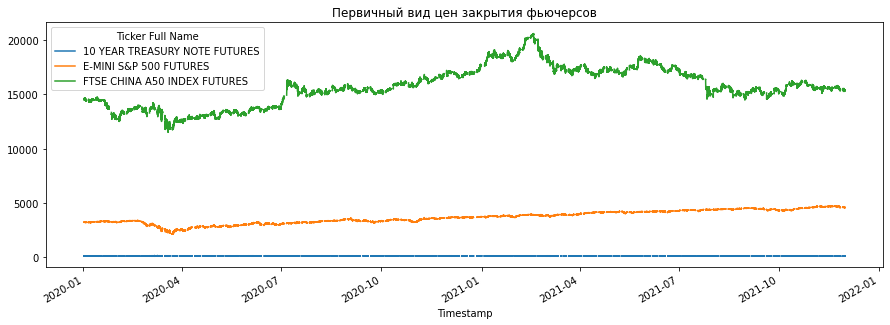

In [8]:
# Визуализация первичных исходных данных
data.plot(title="Первичный вид цен закрытия фьючерсов")

#### Вывод: На первый взгляд, на указанном графике не прослеживается четкая зависимость между анализируемыми показателями. Кроме того, следует отметить относительно высокую волатильность цен на фьючерсы 'FTSE CHINA A50 INDEX FUTURES', которая выделяется на фоне более стабильных цен двух других инструментов. Однако, данная стабильность может быть следствием разброса данных, о котором было упомянуто ранее. Следовательно, для дальнейшего анализа необходимо провести масштабирование данных.

## Этап 6
Строим график с масштабированием MinMax.

<AxesSubplot:title={'center':'С масштабированием MinMax'}, xlabel='Timestamp'>

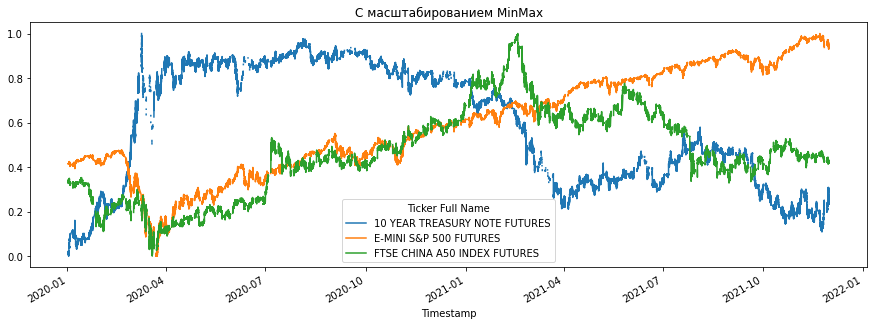

In [9]:
scale_data = pd.DataFrame(MinMaxScaler().fit_transform(data), columns=data.columns, index=data.index)
scale_data.plot(title="С масштабированием MinMax")

#### Вывод: После масштабирования данных, график указывает на несколько иную картину, которая дает нам более четкое понимания поведения цен анализируемых фьючерсов. В первую очередь следует отметить наличие волатильности также у показателя '10 YEAR TREASURY NOTE FUTURES', наряду с 'FTSE CHINA A50 INDEX FUTURES'. Кроме того, на масштабированном графике можно визуально определить наличие некой корреляции между анализируемыми показателями.¶

## Этап 7.
Далее рассчитаем степень корреляции данных.

In [10]:
# Корреляция за анализируемый период
print(data['10 YEAR TREASURY NOTE FUTURES'].corr(data['E-MINI S&P 500 FUTURES']))
print(data['10 YEAR TREASURY NOTE FUTURES'].corr(data['FTSE CHINA A50 INDEX FUTURES']))
print(data['E-MINI S&P 500 FUTURES'].corr(data['FTSE CHINA A50 INDEX FUTURES']))

print()

# Ковариации за анализируемый период
print (data ['10 YEAR TREASURY NOTE FUTURES']. cov (data ['E-MINI S&P 500 FUTURES']))
print (data ['10 YEAR TREASURY NOTE FUTURES']. cov (data ['FTSE CHINA A50 INDEX FUTURES']))
print (data ['E-MINI S&P 500 FUTURES']. cov (data ['FTSE CHINA A50 INDEX FUTURES']))

-0.6199096468684904
-0.11975177770306818
0.586984818214174

-1277.649280697176
-739.0643442358047
606458.7504588456


#### Вывод: Рассмотрев полученные данные можно сделать вывод, что между показателями 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES присутствует наибольший уровень отрицательной корреляции на уровне -0,61. При этом фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES практически не коррелируют между собой. Между показателями E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES присутствует положительная корреляция на уровне 0,58.¶

#### Этап 8.
Исходя их графиков можно предположить, что в различные периоды уровень корреляции между показателями может отличаться. Следовательно, ниже проанализируем данные показатели в разбивке по периодам.

-0.7702491259661157
-0.5656452044615929
0.7509856060514972


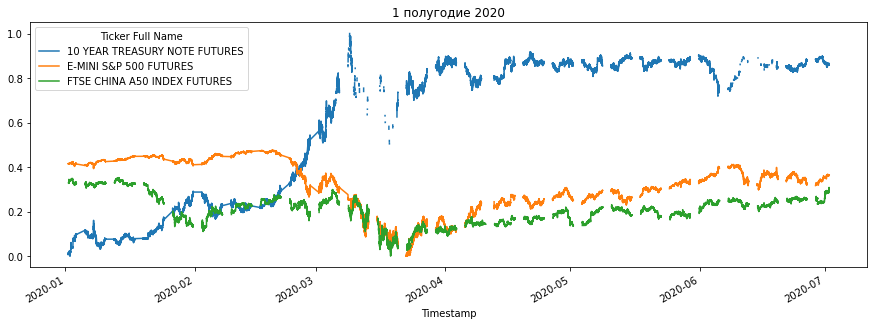

In [11]:
scale_data.loc['2020-01-01':'2020-07-01'].plot(title="1 полугодие 2020")
df111=scale_data.loc['2020-01-01':'2020-07-01']
print(df111['10 YEAR TREASURY NOTE FUTURES'].corr(df111['E-MINI S&P 500 FUTURES']))
print(df111['10 YEAR TREASURY NOTE FUTURES'].corr(df111['FTSE CHINA A50 INDEX FUTURES']))
print(df111['E-MINI S&P 500 FUTURES'].corr(df111['FTSE CHINA A50 INDEX FUTURES']))

#### Вывод: Как следует из вышеприведенных данных, уровень корреляции за первое полугодие 2020 года существенно выше практически по всем показателям. При этом между фьючерсами 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES уровень отрицательной корреляции находится вышесреднего деления и соответствует -0,7703. Между фьючерсами E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES корреляция также находится в интервале вышесреднего значения, при этом корреляция является положительной и соответствует 0,7509. Таким образом можно предположить, что в заданный промежуток времени цена на фьючерсы E-MINI S&P 500 FUTURES существенно завесила от рыночной конъектуры Китая и в значительной степени следовала рыночному поведению фьючерсов FTSE CHINA A50 INDEX FUTURES. При этом цена на фьючерсы 10 YEAR TREASURY NOTE FUTURES имела отрицательную корреляцию с обоими показателями.

-0.6976783800091092
-0.7806285466579689
0.827369400774913


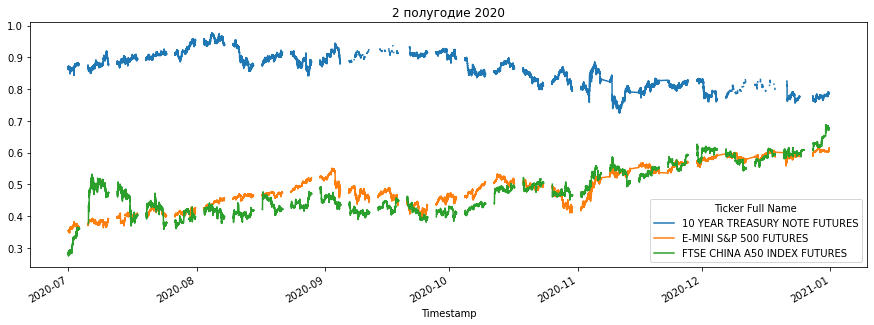

In [12]:
scale_data.loc['2020-07-01':'2021-01-01'].plot(title="2 полугодие 2020")
df222=scale_data.loc['2020-07-01':'2021-01-01']
print(df222['10 YEAR TREASURY NOTE FUTURES'].corr(df222['E-MINI S&P 500 FUTURES']))
print(df222['10 YEAR TREASURY NOTE FUTURES'].corr(df222['FTSE CHINA A50 INDEX FUTURES']))
print(df222['E-MINI S&P 500 FUTURES'].corr(df222['FTSE CHINA A50 INDEX FUTURES']))

#### Вывод: Как следует из вышеприведенных данных, зависимость между показателями продолжает сохранять заданную выше тенденцию и в течение второго полугодия 2020 года. Цена на фьючерсы E-MINI S&P 500 FUTURES в заданный промежуток времени продолжает сохранять тенденцию следования за конъюктурой Китайского рынка. Более того, уровень корреляции между E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES продолжает повысился на 10% и составил 0,8274. При этом цена на фьючерсы 10 YEAR TREASURY NOTE FUTURES также продолжает сохранять отрицательную корреляцию с FTSE CHINA A50 INDEX FUTURES и, следовательно, с ценой на фьючерсы E-MINI S&P 500 FUTURES.

-0.47963409465245516
-0.142816275844962
0.8705519812593674


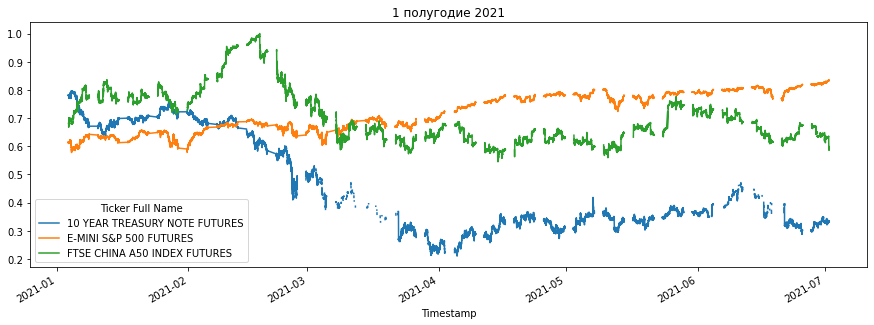

In [13]:
scale_data.loc['2021-01-01':'2021-07-01'].plot(title="1 полугодие 2021")
df333=scale_data.loc['2020-01-01':'2021-07-01']
print(df333['10 YEAR TREASURY NOTE FUTURES'].corr(df333['E-MINI S&P 500 FUTURES']))
print(df333['10 YEAR TREASURY NOTE FUTURES'].corr(df333['FTSE CHINA A50 INDEX FUTURES']))
print(df333['E-MINI S&P 500 FUTURES'].corr(df333['FTSE CHINA A50 INDEX FUTURES']))

#### Вывод: Цена на фьючерсы E-MINI S&P 500 FUTURES в заданный промежуток времени также продолжает сохранять тенденцию следования за конъектурой Китайского рынка, о чем свидетельствует растущий уровень корреляции между фьючерсами E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES, который еще больше увеличил свой показатель до уровня 0,8706, что на 15,9% выше чем указанный показатель на первое полугодие 2020 года и на 5,2% выше чем указанный показатель за второе полугодие 2020 года.При этом уровень корреляции цен на фьючерсы 10 YEAR TREASURY NOTE FUTURES с FTSE CHINA A50 INDEX FUTURES существенно снизился в сравнении с 2-м полугодием 2020 года и составил -0,1428, что может свидетельствовать о практической независимости данных между собой. Уровень корреляции цен на фьючерсы10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES также снизился до слабого уровня и составил -0,4796.¶

-0.6108489117494562
-0.01327147351087086
-0.2606766122317496


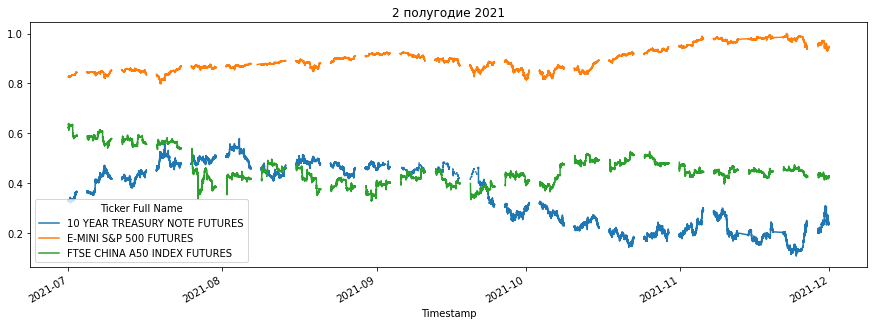

In [14]:
scale_data.loc['2021-07-01':'2021-12-01'].plot(title="2 полугодие 2021")
df444=scale_data.loc['2021-07-01':'2021-12-01']
print(df444['10 YEAR TREASURY NOTE FUTURES'].corr(df444['E-MINI S&P 500 FUTURES']))
print(df444['10 YEAR TREASURY NOTE FUTURES'].corr(df444['FTSE CHINA A50 INDEX FUTURES']))
print(df444['E-MINI S&P 500 FUTURES'].corr(df444['FTSE CHINA A50 INDEX FUTURES']))

#### Вывод: Второе полугодие 2021 года показало существенное изменение картины, что скорее всего было связано с распоряжением администрации бывшего президента США Дональда Трампа, запрещающим инвестиции американских инвестиционных и пенсионных фондов в китайские компании, которые контролируются или связаны с военными КНР. В следствии данного распоряжения, как известно, S&P Dow Jones Indices принял решение исключить десять китайских компаний из своих индексов. Таким образом зависимость между ценными бумагами E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES существенно снизилась, уровень корреляции упал до 0,2607, тогда как за предыдущий анализируемый перерод данный показатель был равен 0,8706.Уровень корреляции между показателями 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES, который и ранее не был высоким, снизился практически до нулевой отметки и составил -0,0133.При этом связь между показателями 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES значительно укрепилась и составила -0,6108, сохранив свое отрицательное значение.¶

## Этап 9.
При анализе данных были выявлены пропуски данных в некоторых периодах. Далее рассмотрим этот вопрос более подробно. В первую очередь, выведем график пропусков за период в целом и в разбивке за каждое полугодие анализируемого периода.

<AxesSubplot:title={'center':'Пропуски за 2 полугодие 2021'}, xlabel='Timestamp'>

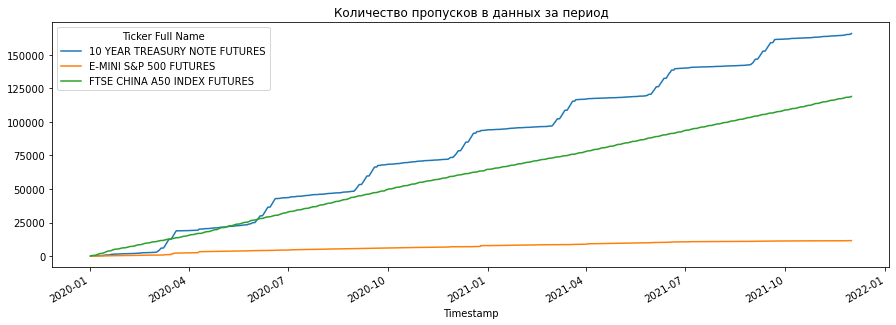

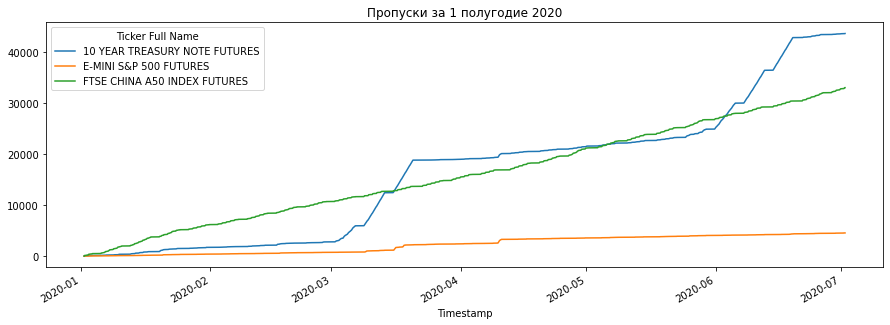

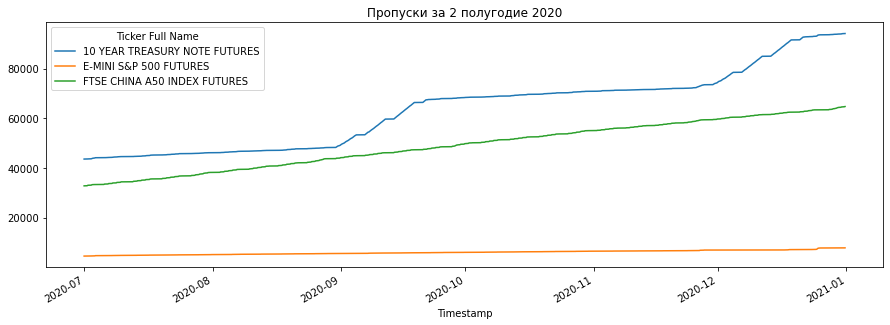

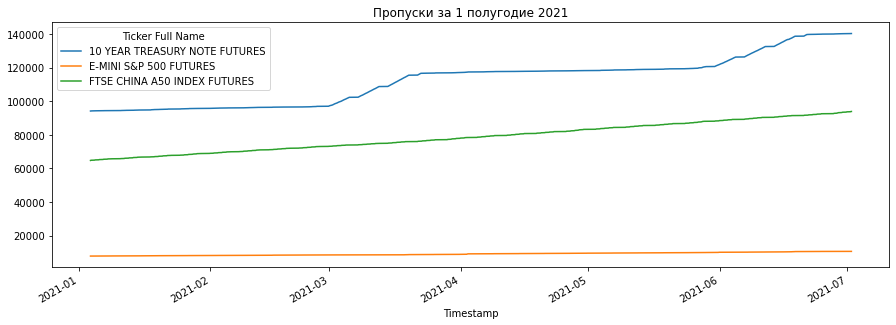

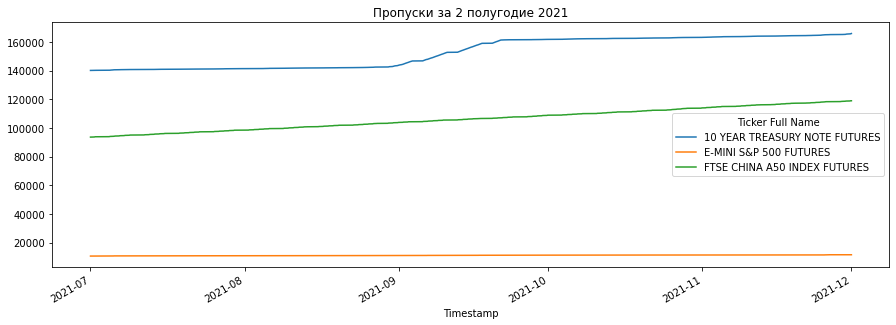

In [15]:
# Выведем графики пропусков за период и по полугодиям
nan_cumsum = data.isna().cumsum()
nan_cumsum.plot(title="Количество пропусков в данных за период")
nan_cumsum.loc['2020-01-01':'2020-07-01'].plot(title="Пропуски за 1 полугодие 2020")
nan_cumsum.loc['2020-07-01':'2021-01-01'].plot(title="Пропуски за 2 полугодие 2020")
nan_cumsum.loc['2021-01-01':'2021-07-01'].plot(title="Пропуски за 1 полугодие 2021")
nan_cumsum.loc['2021-07-01':'2021-12-01'].plot(title="Пропуски за 2 полугодие 2021")

#### Вывод: Можно отметить, что наибольшее количество разрывов присутствует в данных 10 YEAR TREASURY NOTE FUTURES. При этом имеет место скачкообразный прирост по отсутствующим данным, что свидетельствует о том, что в определенные периоды имелись существенные пропуски данных. Более того, следует отметить наличие некой закономерности в указанных пропусках. Таким образом, в каждом из анализируемых годов данные отсутствовали в аналогичные периоды, а именно: с март-апрель, июнь-июль, сентябрь-октябрь и декабрь-январь. У двух других показателей, FTSE CHINA A50 INDEX FUTURES и E-MINI S&P 500 FUTURE, отсутствие данных возникает равномерно, в течение всего анализируемого периода. При этом на графике наглядно видно, что E-MINI S&P 500 FUTURE содержит наименьшее количество пропусков, указанная кривая практически не растет по истечению времени, на фоне существенного роста двух других показателей.¶

## Этап 10.
Далее выведем количество разрывов в данных, а также общее количество значений в разрезе каждого показателя. Данный шаг даст нам понимания доли отсутствующих показателей в общем массиве анализируемых данных.

In [16]:
# Посмотрим количество NaN по отдельности по каждому фьючерсу
data.isna().sum()

Ticker Full Name
10 YEAR TREASURY NOTE FUTURES    165921
E-MINI S&P 500 FUTURES            11537
FTSE CHINA A50 INDEX FUTURES     118993
dtype: int64

In [17]:
# Рассмотрим сколько всего значений по отдельному показателю
data.count()

Ticker Full Name
10 YEAR TREASURY NOTE FUTURES    518515
E-MINI S&P 500 FUTURES           672899
FTSE CHINA A50 INDEX FUTURES     565443
dtype: int64

#### Вывод: Из полученной информации можно отметить, что наибольшее количество разрывов имеется у показателя 10 YEAR TREASURY NOTE FUTURES, где на общее количество данных приходится 31,9% разрывов, что практически равно одной трети. Данное соотношение по показателю E-MINI S&P 500 FUTURE равно 1,7%, а по показателю FTSE CHINA A50 INDEX FUTURES равно 21,0%. В целом, на общее число имеющихся данных - 1 756 857, присутствуют 296 451 количество разрывов, соотношение данных показателей равно 16,8%.

## Этап 11.
Для последующего анализа и постройки прогнозов необходимо определиться со следующим: либо мы удаляем пусты значения, либо заменяем их, к примеру на среднюю (медиану и т.д.). Полагаем, что если бы пустых значений было до 10%, либо данных было более 10 млн, то применив функцию dropna мы продолжили бы работать с данными. Но так как пустых значений порядка 16% от 1,7 млн, то предлагается установить замену на медиану. Берем медиану, так как это наиболее приближенный показатель по сравнению со средней.

In [18]:
for x in data.columns:
    data[x].fillna(data[x].median(), inplace=True)
data

Ticker Full Name     10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                                    
2020-01-01 18:01:00                        128.312                 3236.25   
2020-01-01 18:02:00                        128.312                 3234.75   
2020-01-01 18:03:00                        128.312                 3235.25   
2020-01-01 18:04:00                        128.312                 3236.00   
2020-01-01 18:05:00                        128.328                 3235.50   
...                                            ...                     ...   
2021-11-30 23:55:00                        135.000                 4605.75   
2021-11-30 23:56:00                        135.000                 4606.75   
2021-11-30 23:57:00                        135.000                 4606.50   
2021-11-30 23:58:00                        135.000                 4606.50   
2021-11-30 23:59:00                        135.000                 4606.50   

Ticker Full Name     FTSE CHINA A50 INDEX FUTURES  
Timestamp                                          
2020-01-01 18:01:00                       15604.0  
2020-01-01 18:02:00                       15604.0  
2020-01-01 18:03:00                       15604.0  
2020-01-01 18:04:00                       15604.0  
2020-01-01 18:05:00                       15604.0  
...                                           ...  
2021-11-30 23:55:00                       15390.0  
2021-11-30 23:56:00                       15390.0  
2021-11-30 23:57:00                       15388.0  
2021-11-30 23:58:00                       15390.0  
2021-11-30 23:59:00                       15393.0  

[684436 rows x 3 columns]

## Этап 12.
После замены всех пропусков на медианы по каждому отдельному показателю, начнем работу по постороннею прогнозных значений.

In [19]:
def run_model(model, X, y):
    model.fit(X, y)
    y_pred = model.predict(X)
    return mean_absolute_error(y, y_pred)

In [20]:
for x in data.columns:
    X = data[ [x] ].values
    y = data[x].values

    score = run_model(DummyRegressor(strategy="median"), X, y)
    print(score, x, np.std(y))

2.445805603445758 10 YEAR TREASURY NOTE FUTURES 3.038330731243964
497.80817490605403 E-MINI S&P 500 FUTURES 581.5105060704806
1169.4575489892409 FTSE CHINA A50 INDEX FUTURES 1610.09131265


## Этап 13.
Применим метод скользящего окна прогнозирования временных рядов.

In [21]:
data

Ticker Full Name     10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                                    
2020-01-01 18:01:00                        128.312                 3236.25   
2020-01-01 18:02:00                        128.312                 3234.75   
2020-01-01 18:03:00                        128.312                 3235.25   
2020-01-01 18:04:00                        128.312                 3236.00   
2020-01-01 18:05:00                        128.328                 3235.50   
...                                            ...                     ...   
2021-11-30 23:55:00                        135.000                 4605.75   
2021-11-30 23:56:00                        135.000                 4606.75   
2021-11-30 23:57:00                        135.000                 4606.50   
2021-11-30 23:58:00                        135.000                 4606.50   
2021-11-30 23:59:00                        135.000                 4606.50   

Ticker Full Name     FTSE CHINA A50 INDEX FUTURES  
Timestamp                                          
2020-01-01 18:01:00                       15604.0  
2020-01-01 18:02:00                       15604.0  
2020-01-01 18:03:00                       15604.0  
2020-01-01 18:04:00                       15604.0  
2020-01-01 18:05:00                       15604.0  
...                                           ...  
2021-11-30 23:55:00                       15390.0  
2021-11-30 23:56:00                       15390.0  
2021-11-30 23:57:00                       15388.0  
2021-11-30 23:58:00                       15390.0  
2021-11-30 23:59:00                       15393.0  

[684436 rows x 3 columns]

## Этап 14.
Далее будем проводить итерации для сдвига: на 1 месяц, на 2 месяца, на 3 месяца, на 4 месяца.

## Этап 14.1
Строим прогноз сдвига на 1 месяц.

In [22]:
data_re = data.resample("1m").agg(["mean", "max", "min", "median", "std"])

data_agg = pd.DataFrame()
for x in data.columns:
    data_agg[x] = data_re[x]["median"] #этатлон, это с чем мы сверяемся (какую проблемы хотим решить или что будем прогнозировать)
    
    
data_agg.head()

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-02-29                        131.187                 3341.25   
2020-03-31                        135.000                 2586.25   
2020-04-30                        138.953                 2785.00   
2020-05-31                        139.000                 2919.50   

            FTSE CHINA A50 INDEX FUTURES  
Timestamp                                 
2020-01-31                       14447.5  
2020-02-29                       13610.0  
2020-03-31                       13167.5  
2020-04-30                       13005.0  
2020-05-31                       13342.5

In [23]:
data_re

10 YEAR TREASURY NOTE FUTURES                                       \
                                    mean      max      min   median       std   
Timestamp                                                                       
2020-01-31                    129.931969  135.000  128.156  129.359  1.478438   
2020-02-29                    131.725236  135.000  130.234  131.187  1.202587   
2020-03-31                    136.175173  140.703  134.484  135.000  1.480730   
2020-04-30                    138.471135  139.671  135.000  138.953  1.144078   
2020-05-31                    138.516636  139.609  135.000  139.000  1.360512   
2020-06-30                    136.538207  139.484  135.000  135.000  1.916930   
2020-07-31                    139.048122  140.187  135.000  139.375  1.236130   
2020-08-31                    139.059531  140.390  135.000  139.406  1.470824   
2020-09-30                    136.700031  140.015  135.000  135.000  2.217288   
2020-10-31                    138.562151  139.765  135.000  138.843  1.115470   
2020-11-30                    137.855909  139.265  135.000  138.265  1.145053   
2020-12-31                    136.018260  138.703  135.000  135.000  1.390374   
2021-01-31                    136.939370  138.156  135.000  136.937  0.646536   
2021-02-28                    136.052803  137.296  133.296  136.234  0.886503   
2021-03-31                    133.894266  135.000  130.828  135.000  1.545859   
2021-04-30                    132.097594  135.000  130.796  132.015  0.728719   
2021-05-31                    132.791869  135.000  131.828  132.515  0.871979   
2021-06-30                    133.943450  135.000  131.765  135.000  1.318670   
2021-07-31                    133.798960  135.187  132.187  133.875  0.691984   
2021-08-31                    134.198150  135.421  133.296  134.156  0.482085   
2021-09-30                    133.976522  135.000  131.250  135.000  1.365150   
2021-10-31                    131.217516  135.000  129.968  130.968  1.006995   
2021-11-30                    131.114062  135.000  129.515  130.734  1.322690   

           E-MINI S&P 500 FUTURES                                         \
                             mean      max      min   median         std   
Timestamp                                                                  
2020-01-31            3284.202878  3688.00  3182.00  3280.75   57.160052   
2020-02-29            3294.890452  3688.00  2853.75  3341.25  126.685267   
2020-03-31            2699.413359  3688.00  2174.00  2586.25  345.268082   
2020-04-30            2785.958490  3688.00  2428.00  2785.00  221.529647   
2020-05-31            2929.160602  3688.00  2761.50  2919.50  122.206466   
2020-06-30            3107.706952  3688.00  2938.00  3100.25   95.212729   
2020-07-31            3203.773433  3688.00  3063.50  3205.75   82.773964   
2020-08-31            3387.178881  3688.00  3255.25  3373.50   73.581050   
2020-09-30            3374.134471  3688.00  3199.50  3361.75   93.626055   
2020-10-31            3419.203339  3688.00  3226.50  3429.50   76.050027   
2020-11-30            3545.992598  3688.00  3243.50  3565.75   96.104666   
2020-12-31            3689.782183  3751.50  3605.25  3688.00   25.471190   
2021-01-31            3784.957480  3861.25  3656.25  3794.00   46.603317   
2021-02-28            3879.485640  3959.00  3688.00  3896.25   53.201989   
2021-03-31            3902.243656  3988.25  3688.00  3913.75   58.028622   
2021-04-30            4115.448506  4210.50  3688.00  4133.25   85.232370   
2021-05-31            4157.021334  4237.75  3688.00  4169.50   75.856547   
2021-06-30            4223.400506  4298.00  3688.00  4229.75   76.728416   
2021-07-31            4344.568766  4422.25  3688.00  4352.50   70.132393   
2021-08-31            4442.412605  4542.00  3688.00  4439.75   63.451049   
2021-09-30            4444.881629  4548.00  3688.00  4461.50   98.529094   
2021-10-31            4442.249519  4615.00  3688.00  4447.00  108.460800   
2021

In [24]:
shifts = [1, 2, 3, 4]
agg_funcs = ["mean", "max", "min", "median", "std"]

In [25]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            data_agg["{}_{}_{}".format(x, shift, agg_func)] = data_re[x][agg_func].shift(shift).fillna(method="bfill")
    
data_agg

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-02-29                        131.187                 3341.25   
2020-03-31                        135.000                 2586.25   
2020-04-30                        138.953                 2785.00   
2020-05-31                        139.000                 2919.50   
2020-06-30                        135.000                 3100.25   
2020-07-31                        139.375                 3205.75   
2020-08-31                        139.406                 3373.50   
2020-09-30                        135.000                 3361.75   
2020-10-31                        138.843                 3429.50   
2020-11-30                        138.265                 3565.75   
2020-12-31                        135.000                 3688.00   
2021-01-31                        136.937                 3794.00   
2021-02-28                        136.234                 3896.25   
2021-03-31                        135.000                 3913.75   
2021-04-30                        132.015                 4133.25   
2021-05-31                        132.515                 4169.50   
2021-06-30                        135.000                 4229.75   
2021-07-31                        133.875                 4352.50   
2021-08-31                        134.156                 4439.75   
2021-09-30                        135.000                 4461.50   
2021-10-31                        130.968                 4447.00   
2021-11-30                        130.734                 4674.25   

            FTSE CHINA A50 INDEX FUTURES  \
Timestamp                                  
2020-01-31                       14447.5   
2020-02-29                       13610.0   
2020-03-31                       13167.5   
2020-04-30                       13005.0   
2020-05-31                       13342.5   
2020-06-30                       13752.5   
2020-07-31                       15482.5   
2020-08-31                       15417.5   
2020-09-30                       15385.0   
2020-10-31                       15759.0   
2020-11-30                       16393.0   
2020-12-31                       16901.0   
2021-01-31                       18441.0   
2021-02-28                       19096.0   
2021-03-31                       17262.0   
2021-04-30                       17106.0   
2021-05-31                       17147.0   
2021-06-30                       17390.0   
2021-07-31                       16579.0   
2021-08-31                       15400.0   
2021-09-30                       15331.0   
2021-10-31                       15839.0   
2021-11-30                       15581.0   

            10 YEAR TREASURY NOTE FUTURES_1_mean  \
Timestamp                                          
2020-01-31                            129.931969   
2020-02-29                            129.931969   
2020-03-31                            131.725236   
2020-04-30                            136.175173   
2020-05-31                            138.471135   
2020-06-30                            138.516636   
2020-07-31                            136.538207   
2020-08-31                            139.048122   
2020-09-30                            139.059531   
2020-10-31                            136.700031   
2020-11-30                            138.562151   
2020-12-31                            137.855909   
2021-01-31                            136.018260   
2021-02-28                            136.939370   
2021-03-31                            136.052803   
2021-04-30                            133.894266   
2021-05-31                            132.097594   
2021-06-30                            132.791869   
2021-07-31                            133.943450   
2021-08-31                            133.798960   
2021-09-30                            134

In [26]:
# Выведем для каждого фьючерса отдельные показатели
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            score = mean_absolute_error(data_agg[x], data_agg["{}_{}_{}".format(x, shift, agg_func)])
            print(x, shift, agg_func, score)

10 YEAR TREASURY NOTE FUTURES 1 mean 1.5816268177499564
10 YEAR TREASURY NOTE FUTURES 1 max 2.262173913043477
10 YEAR TREASURY NOTE FUTURES 1 min 2.223565217391305
10 YEAR TREASURY NOTE FUTURES 1 median 2.0216956521739142
10 YEAR TREASURY NOTE FUTURES 1 std 133.85394203505138
10 YEAR TREASURY NOTE FUTURES 2 mean 2.3435032263701823
10 YEAR TREASURY NOTE FUTURES 2 max 2.60591304347826
10 YEAR TREASURY NOTE FUTURES 2 min 2.6365217391304343
10 YEAR TREASURY NOTE FUTURES 2 median 2.825478260869567
10 YEAR TREASURY NOTE FUTURES 2 std 133.83344450428925
10 YEAR TREASURY NOTE FUTURES 3 mean 2.379327900688038
10 YEAR TREASURY NOTE FUTURES 3 max 2.9537391304347818
10 YEAR TREASURY NOTE FUTURES 3 min 3.068608695652175
10 YEAR TREASURY NOTE FUTURES 3 median 2.164565217391307
10 YEAR TREASURY NOTE FUTURES 3 std 133.82851893076275
10 YEAR TREASURY NOTE FUTURES 4 mean 2.968969778520539
10 YEAR TREASURY NOTE FUTURES 4 max 2.935434782608695
10 YEAR TREASURY NOTE FUTURES 4 min 3.30713043478261
10 YEAR T

10 YEAR TREASURY NOTE FUTURES
dm -2.6282138596491276 0.7152958875374977
ln -5.336206632215926 5.160050297795016
dt -1.89715 0.731049529101823
rf -1.6172264999999946 0.7192870782732015
et -1.6439214999999776 0.6536128800600635
xgb -1.7995673229980476 1.0952247546190192
ctb -1.9106311136080105 0.7659457685492169
E-MINI S&P 500 FUTURES
dm -635.4759941520467 302.4402436346542
ln -836.5281823611265 594.1546342318408
dt -288.525 43.15679552515456
rf -316.87883416666665 232.47083316457454
et -328.7066 238.02573870181817
xgb -341.77887939453126 214.7847884101923
ctb -348.8089558276765 230.03671745432976
FTSE CHINA A50 INDEX FUTURES
dm -1569.2421637426896 969.6915720517303
ln -3335.2504952909344 1845.1946256329506
dt -1016.0200000000001 441.8918449123043
rf -977.9619750000002 399.42289659654216
et -816.5751000000001 274.39715212746813
xgb -1024.3790234374999 304.27009416555484


/opt/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


ctb -1086.7161093465943 457.3982481191453


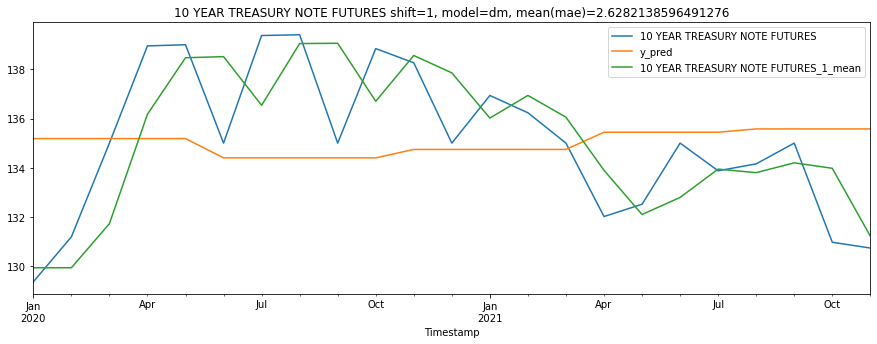

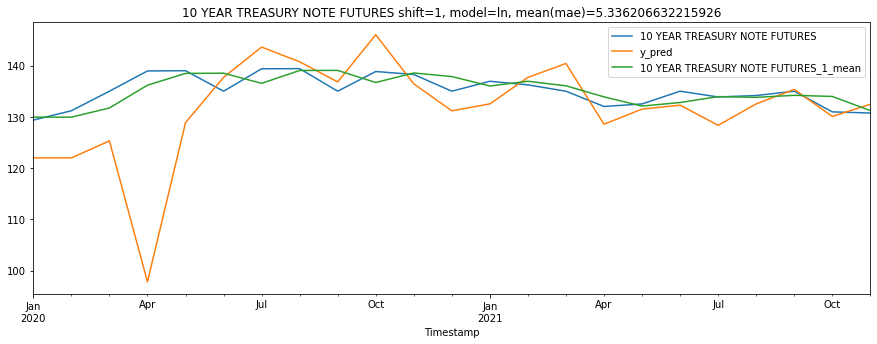

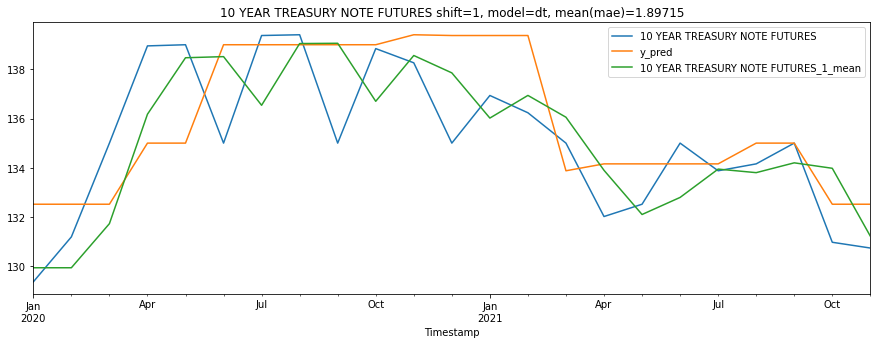

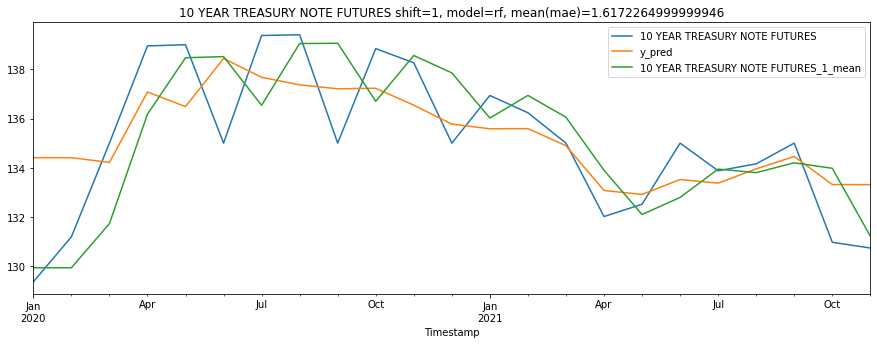

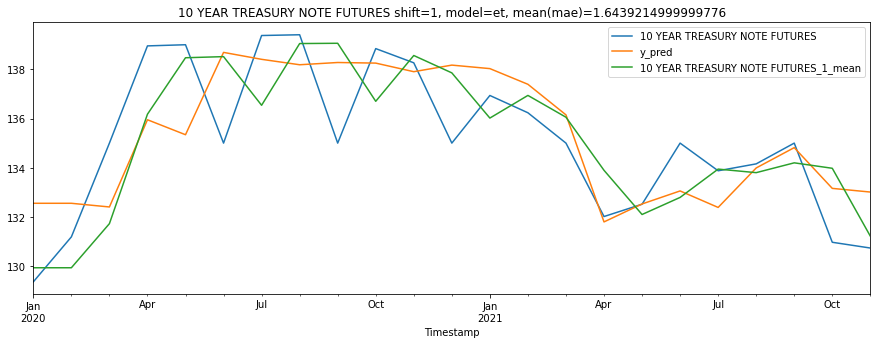

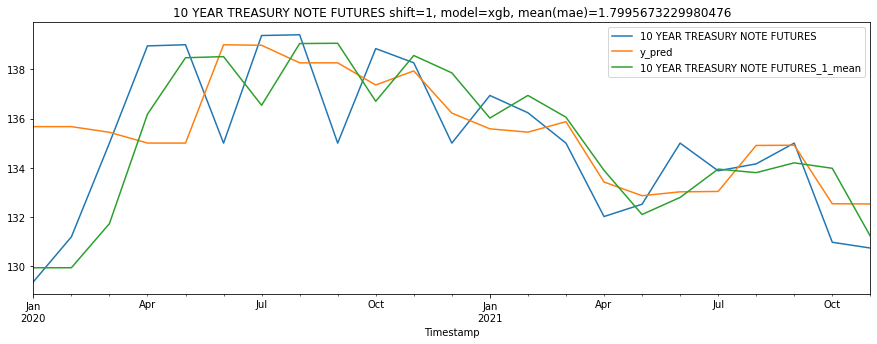

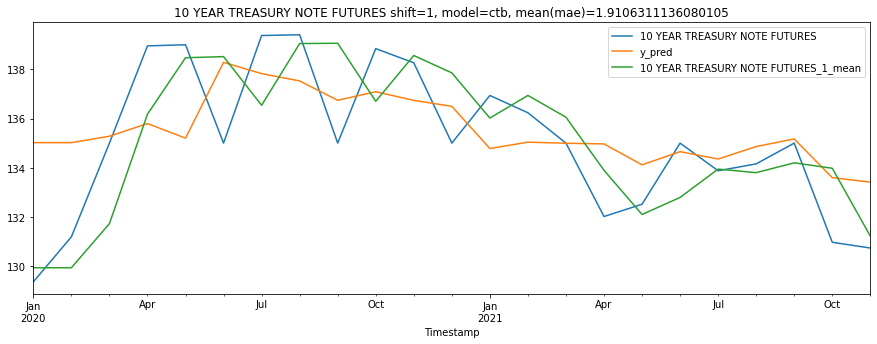

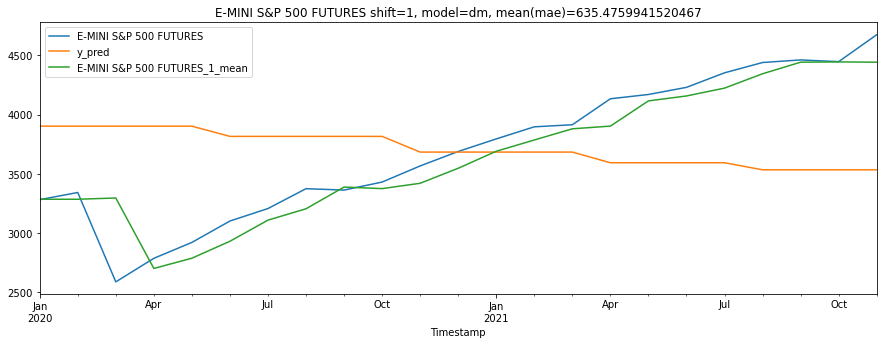

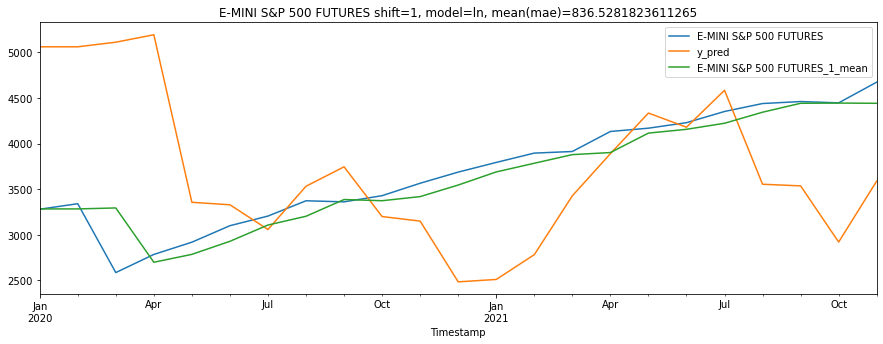

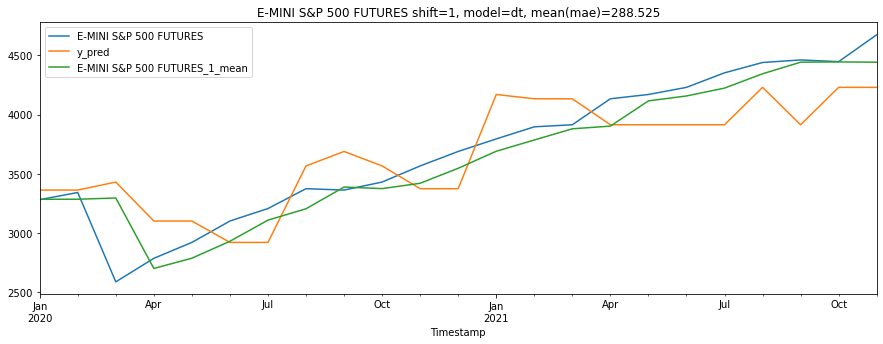

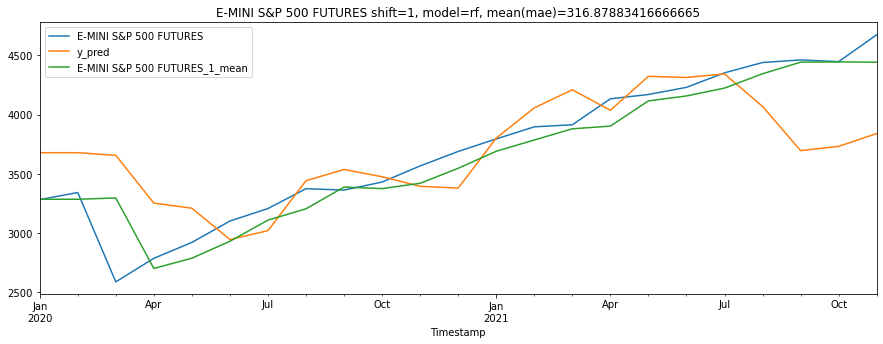

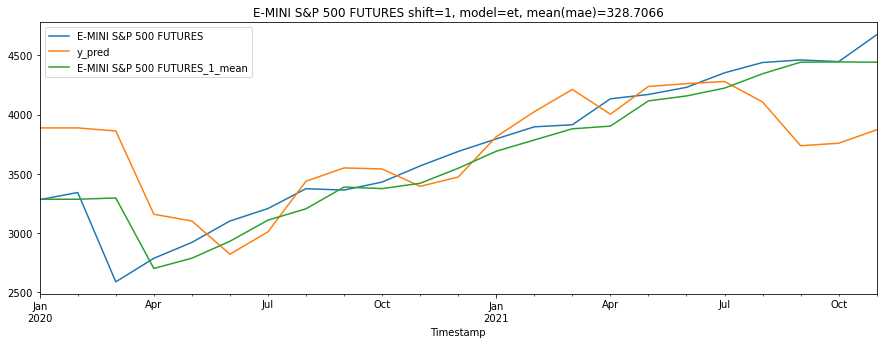

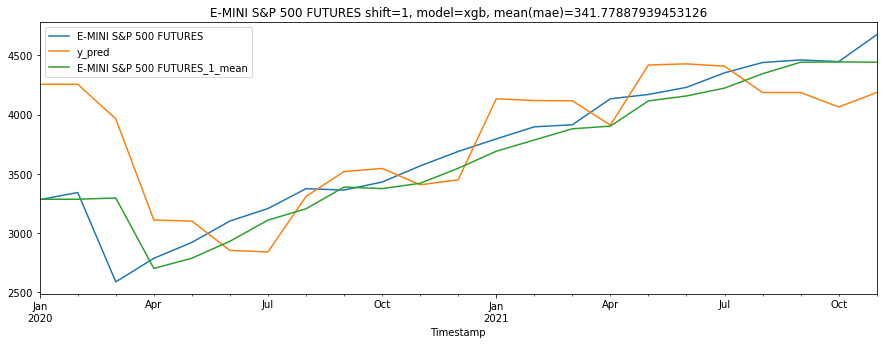

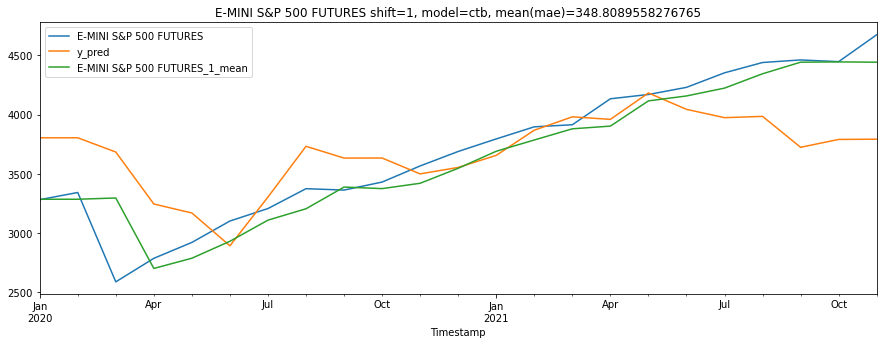

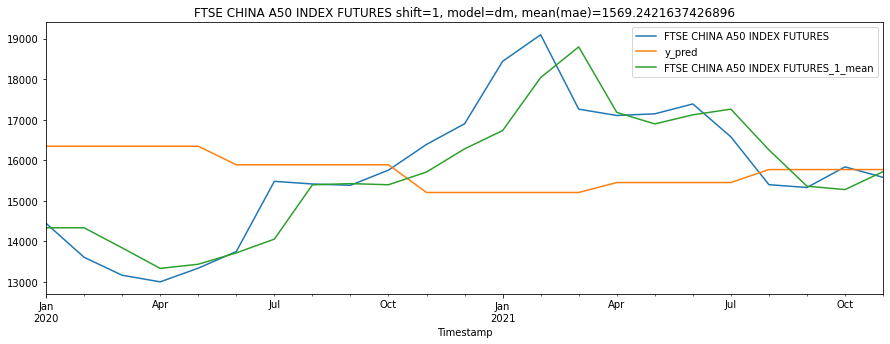

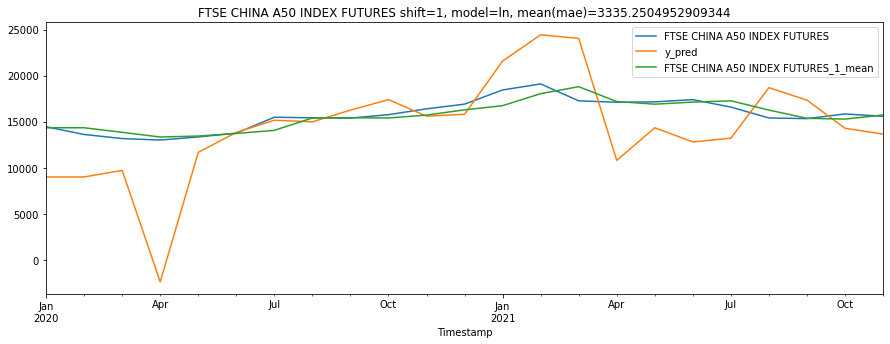

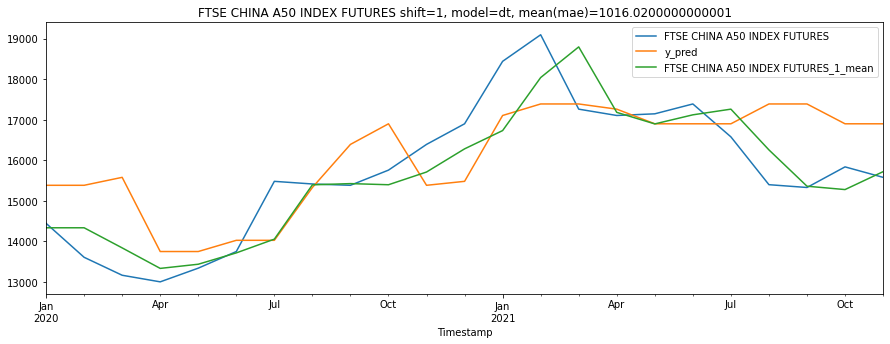

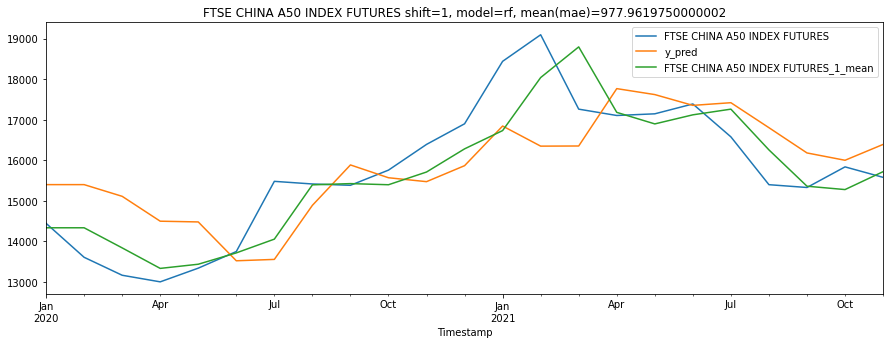

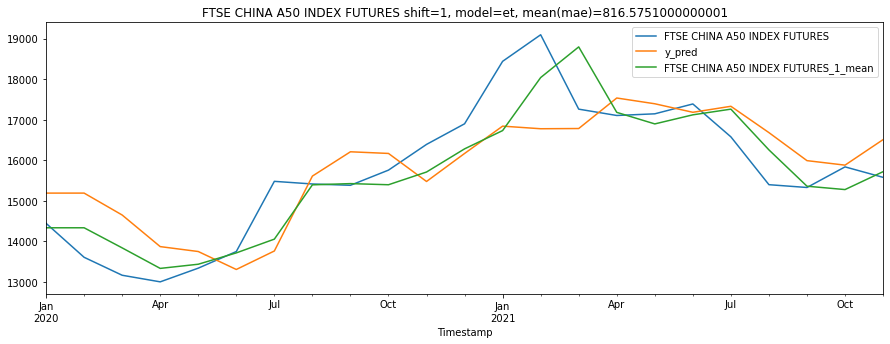

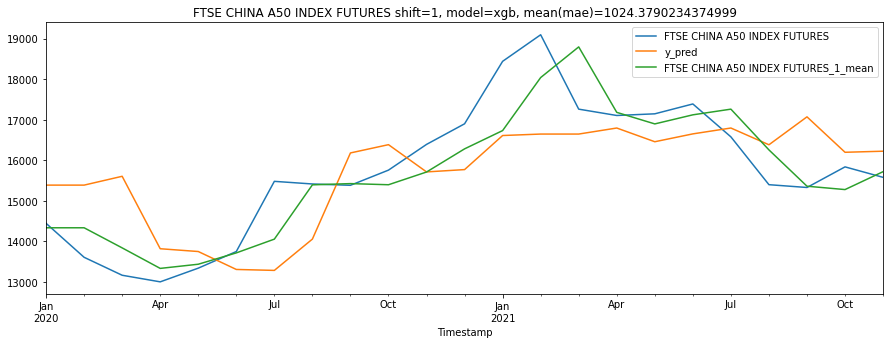

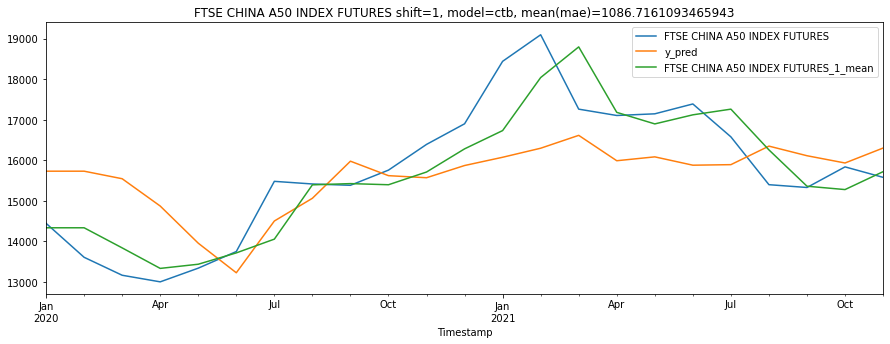

In [27]:
# Будем проводить итерации по следующим моделям: DummyRegressor, ln_pipe, DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, XGBRegressor, CatBoostRegressor
shift=1
for label in data.columns:
    feats = [x for x in data_agg.columns if "_{}_".format(shift) in x]
    X = data_agg[feats].values
    y = data_agg[label].values

    ln_pipe = Pipeline([('scaler', StandardScaler()), ('ln', LinearRegression())])
    models = [
        ("dm", DummyRegressor()),
        ("ln", ln_pipe),
        ("dt", DecisionTreeRegressor(max_depth=10, random_state=0)),
        ("rf", RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("et", ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("xgb", xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0)),
        ("ctb", ctb.CatBoostRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0, verbose=0)),
    ]

    print(label)
    for model_name, model in models:
        scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
        data_agg["y_pred"] = cross_val_predict(model, X, y, cv=5)
        
        roll_feat_mean = "{}_{}_{}".format(label, shift, "mean")
        data_agg[[ label, "y_pred", roll_feat_mean]].plot(title="{} shift={}, model={}, mean(mae)={}".format(label, shift, model_name, np.mean(scores) * -1), figsize=(15, 5))
        print(model_name, np.mean(scores), np.std(scores))

#### Вывод: Из указанных выше числовых значений, а также на основе приведенного графика можно предположить, что наиболее привлекательной моделью является "Случайный лес".

In [28]:
model = RandomForestRegressor()
model.fit(X, y)
eli5.show_weights(model, feature_names=feats)

In [29]:
def plot_importances(label, model, shift=1):
    feats = [x for x in data_agg.columns if "_{}_".format(shift) in x]
    X = data_agg[feats].values
    y = data_agg[label].values

    
    model.fit(X, y)
    return eli5.show_weights(model, feature_names=feats)

Построим прогноз для каждого фьючерса

In [30]:
plot_importances('10 YEAR TREASURY NOTE FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=1)

In [31]:
plot_importances('E-MINI S&P 500 FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=1)

In [32]:
plot_importances('FTSE CHINA A50 INDEX FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=1)

#### Вывод: Рассмотрев три вышеприведенные таблицы можно отметить, что использовав сдвиг на 1 месяц (shift=1), при прогнозе каждый фьючерс в первую очередь учитывает свои параметры. Также стоит отметить, что наибольшую вероятность имеет прогноз цен на фьючерсы "FTSE CHINA A50 INDEX FUTURES", где данный показатель соответствует значению 0,4859 (в идеале данный показатель должен стремиться к 1). Данный показатель вероятности по фьючерсам "E-MINI S&P 500 FUTURES" равен 0,2236, что является самым низким показателем из трех анализируемых финансовых инструментов. Скорее всего данный факт обуславливается тем, что на формирование ценны данного фьючерса относительно в большей степени влияют различные внешнеэкономические факторы, чем в сравнении с прочими анализируемыми финансовыми инструментами.¶
Следует отметить, что при краткосрочном прогнозе каждый показатель предпочитает ориентироваться на собственные параметры, в связи с чем, считаем необходимым построить прогноз на периоды 2, 3 и 4 месяцев.

## Этап 14.2
Строим прогноз сдвига на 2 месяца.

In [33]:
data_re2 = data.resample("2m").agg(["mean", "max", "min", "median", "std"])

data_agg2 = pd.DataFrame()
for x in data.columns:
    data_agg2[x] = data_re2[x]["median"] #этатлон, это с чем мы сверяемся (какую проблемы хотим решить или что будем прогнозироватьь)
    
    
data_agg2.head()

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-03-31                        135.000                 3066.50   
2020-05-31                        138.968                 2854.50   
2020-07-31                        139.015                 3146.00   
2020-09-30                        139.296                 3370.25   

            FTSE CHINA A50 INDEX FUTURES  
Timestamp                                 
2020-01-31                       14447.5  
2020-03-31                       13547.5  
2020-05-31                       13212.5  
2020-07-31                       14995.0  
2020-09-30                       15402.5

In [34]:
data_re2

10 YEAR TREASURY NOTE FUTURES                                       \
                                    mean      max      min   median       std   
Timestamp                                                                       
2020-01-31                    129.931969  135.000  128.156  129.359  1.478438   
2020-03-31                    134.076442  140.703  130.234  135.000  2.602915   
2020-05-31                    138.493539  139.671  135.000  138.968  1.255516   
2020-07-31                    137.813135  140.187  135.000  139.015  2.039300   
2020-09-30                    137.864813  140.390  135.000  139.296  2.224604   
2020-11-30                    138.215516  139.765  135.000  138.515  1.183946   
2021-01-31                    136.460073  138.703  135.000  136.812  1.190860   
2021-03-31                    134.896384  137.296  130.828  135.000  1.674505   
2021-05-31                    132.441501  135.000  130.796  132.359  0.874704   
2021-07-31                    133.871634  135.187  131.765  134.140  1.057263   
2021-09-30                    134.088439  135.421  131.250  134.250  1.025749   
2021-11-30                    131.164934  135.000  129.515  130.843  1.179195   

           E-MINI S&P 500 FUTURES                                         \
                             mean      max      min   median         std   
Timestamp                                                                  
2020-01-31            3284.202878  3688.00  3182.00  3280.75   57.160052   
2020-03-31            2980.259157  3688.00  2174.00  3066.50  398.646960   
2020-05-31            2856.469843  3688.00  2428.00  2854.50  193.364346   
2020-07-31            3156.504573  3688.00  2938.00  3146.00  101.229427   
2020-09-30            3380.573925  3688.00  3199.50  3370.25   84.579437   
2020-11-30            3481.433496  3688.00  3226.50  3481.25  107.217589   
2021-01-31            3735.433249  3861.25  3605.25  3721.00   60.333924   
2021-03-31            3891.678067  3988.25  3688.00  3903.50   56.981097   
2021-05-31            4136.041494  4237.75  3688.00  4158.75   83.356754   
2021-07-31            4283.625211  4422.25  3688.00  4280.75   95.268324   
2021-09-30            4443.634825  4548.00  3688.00  4448.00   82.705102   
2021-11-30            4552.902771  4739.50  3688.00  4595.00  145.006875   

           FTSE CHINA A50 INDEX FUTURES                             \
                                   mean      max      min   median   
Timestamp                                                            
2020-01-31                 14337.797760  15604.0  12687.5  14447.5   
2020-03-31                 13574.935487  15604.0  11502.5  13547.5   
2020-05-31                 13576.882554  15604.0  12330.0  13212.5   
2020-07-31                 14737.658634  16340.0  13300.0  14995.0   
2020-09-30                 15412.478890  15982.5  14927.5  15402.5   
2020-11-30                 15992.560336  17199.0  14992.5  15931.0   
2021-01-31                 17360.876429  19100.0  15604.0  17064.0   
2021-03-31                 17932.007010  20589.0  15604.0  17686.0   
2021-05-31                 17009.057791  18559.0  15604.0  17124.0   
2021-07-31                 16762.853971  18306.0  14556.0  16820.0   
2021-09-30                 15321.515606  16016.0  14487.0  15368.5   
2021-11-30                 15634.734405  16297.0  14827.0  15604.0   

                         
                    std  
Timestamp                
2020-01-31   856.891406  
2020-03-31  1052.176834  
2020-05-31  1023.550723  
2020-07-31   923.517746  
2020-09-30   192.421495  
2020-11-30   434.098878  
2021-01-31  1063.542745  
2021-03-31  1423.923059  
2021-05-31   754.829783  
2021-07-31   896.269924  
2021-09-30   300.755433  
2021-11-30   265.180480

In [35]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            data_agg2["{}_{}_{}".format(x, shift, agg_func)] = data_re2[x][agg_func].shift(shift).fillna(method="bfill")
    
data_agg2

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-03-31                        135.000                 3066.50   
2020-05-31                        138.968                 2854.50   
2020-07-31                        139.015                 3146.00   
2020-09-30                        139.296                 3370.25   
2020-11-30                        138.515                 3481.25   
2021-01-31                        136.812                 3721.00   
2021-03-31                        135.000                 3903.50   
2021-05-31                        132.359                 4158.75   
2021-07-31                        134.140                 4280.75   
2021-09-30                        134.250                 4448.00   
2021-11-30                        130.843                 4595.00   

            FTSE CHINA A50 INDEX FUTURES  \
Timestamp                                  
2020-01-31                       14447.5   
2020-03-31                       13547.5   
2020-05-31                       13212.5   
2020-07-31                       14995.0   
2020-09-30                       15402.5   
2020-11-30                       15931.0   
2021-01-31                       17064.0   
2021-03-31                       17686.0   
2021-05-31                       17124.0   
2021-07-31                       16820.0   
2021-09-30                       15368.5   
2021-11-30                       15604.0   

            10 YEAR TREASURY NOTE FUTURES_1_mean  \
Timestamp                                          
2020-01-31                            129.931969   
2020-03-31                            129.931969   
2020-05-31                            134.076442   
2020-07-31                            138.493539   
2020-09-30                            137.813135   
2020-11-30                            137.864813   
2021-01-31                            138.215516   
2021-03-31                            136.460073   
2021-05-31                            134.896384   
2021-07-31                            132.441501   
2021-09-30                            133.871634   
2021-11-30                            134.088439   

            10 YEAR TREASURY NOTE FUTURES_1_max  \
Timestamp                                         
2020-01-31                              135.000   
2020-03-31                              135.000   
2020-05-31                              140.703   
2020-07-31                              139.671   
2020-09-30                              140.187   
2020-11-30                              140.390   
2021-01-31                              139.765   
2021-03-31                              138.703   
2021-05-31                              137.296   
2021-07-31                              135.000   
2021-09-30                              135.187   
2021-11-30                              135.421   

            10 YEAR TREASURY NOTE FUTURES_1_min  \
Timestamp                                         
2020-01-31                              128.156   
2020-03-31                              128.156   
2020-05-31                              130.234   
2020-07-31                              135.000   
2020-09-30                              135.000   
2020-11-30                              135.000   
2021-01-31                              135.000   
2021-03-31                              135.000   
2021-05-31                              130.828   
2021-07-31                              130.796   
2021-09-30                              131.765   
2021-11-30                              131.250   

            10 YEAR TREASURY NOTE FUTURES_1_median  \
Timestamp                                            
2020-01-31                                 129.359   
2020-03-31                                 129.359   
2020-05-31                                 135.000   

In [36]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            score = mean_absolute_error(data_agg2[x], data_agg2["{}_{}_{}".format(x, shift, agg_func)])
            print(x, shift, agg_func, score)

10 YEAR TREASURY NOTE FUTURES 1 mean 1.9925289670668178
10 YEAR TREASURY NOTE FUTURES 1 max 2.3971666666666684
10 YEAR TREASURY NOTE FUTURES 1 min 3.182166666666665
10 YEAR TREASURY NOTE FUTURES 1 median 1.8476666666666641
10 YEAR TREASURY NOTE FUTURES 1 std 133.7892302930607
10 YEAR TREASURY NOTE FUTURES 2 mean 2.9235693382207466
10 YEAR TREASURY NOTE FUTURES 2 max 3.0234166666666673
10 YEAR TREASURY NOTE FUTURES 2 min 3.965999999999994
10 YEAR TREASURY NOTE FUTURES 2 median 3.049416666666661
10 YEAR TREASURY NOTE FUTURES 2 std 133.75150621057955
10 YEAR TREASURY NOTE FUTURES 3 mean 3.60737503725394
10 YEAR TREASURY NOTE FUTURES 3 max 3.6769999999999974
10 YEAR TREASURY NOTE FUTURES 3 min 4.256416666666662
10 YEAR TREASURY NOTE FUTURES 3 median 3.937333333333328
10 YEAR TREASURY NOTE FUTURES 3 std 133.71640829916998
10 YEAR TREASURY NOTE FUTURES 4 mean 4.825175751906627
10 YEAR TREASURY NOTE FUTURES 4 max 4.392999999999996
10 YEAR TREASURY NOTE FUTURES 4 min 4.601416666666661
10 YEAR 

10 YEAR TREASURY NOTE FUTURES
dm -2.983936296296298 1.2952963563540507
ln -7.911513017843278 4.521900704866206
dt -4.813433333333329 2.123243340845424
rf -2.492040466666663 1.514617189857974
et -2.2354962222222357 1.403781260913647
xgb -2.827077579752601 0.8319330349277267
ctb -2.422805740197847 1.1902035596734046
E-MINI S&P 500 FUTURES
dm -617.0316666666666 294.1360874285538
ln -123.48433774891046 86.2496100911531
dt -346.05 54.81500706923242
rf -299.3383847222223 215.031315310693
et -220.41783333333325 170.87046192409255
xgb -542.2247721354166 303.0616380035696
ctb -281.5157948193969 231.9126658656639
FTSE CHINA A50 INDEX FUTURES
dm -1358.774444444444 934.7411649961026
ln -1841.9736054926518 1083.702966730117
dt -1794.6333333333332 216.48086007261185
rf -1260.0535555555555 631.0140136976288
et -1273.9866666666646 391.9672785039335
xgb -1473.2043619791668 149.805146033716


/opt/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


ctb -1247.6827612512075 611.9741030083726


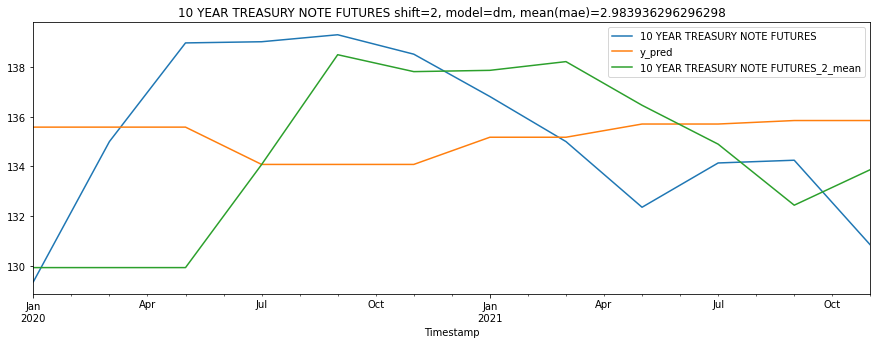

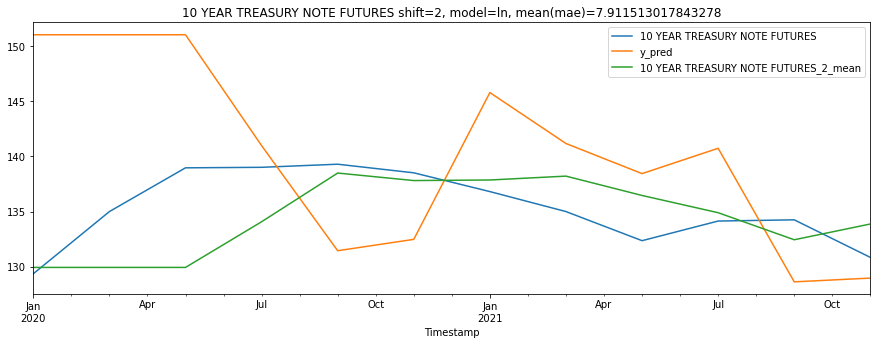

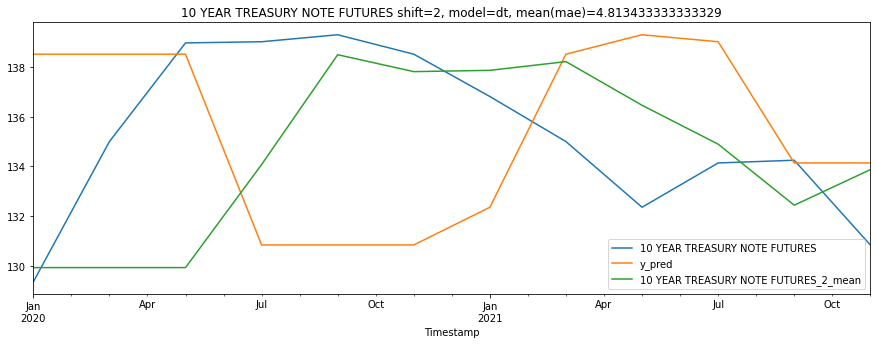

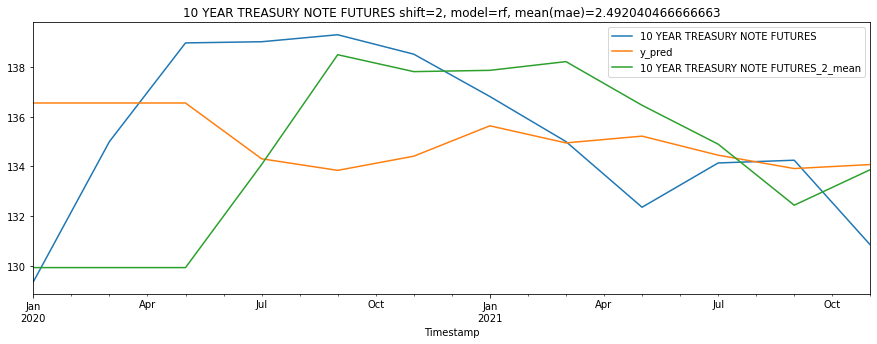

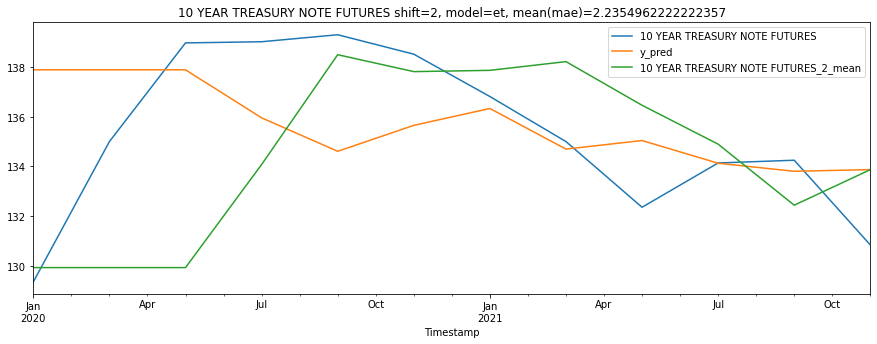

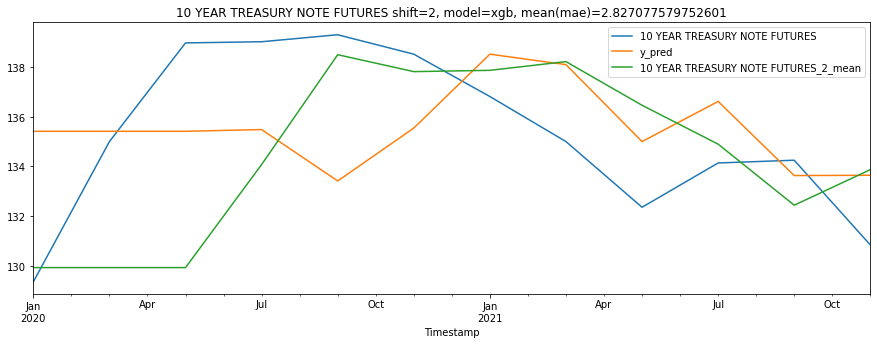

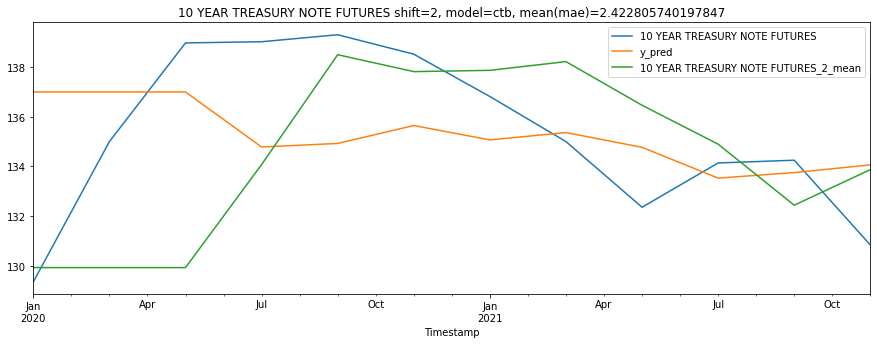

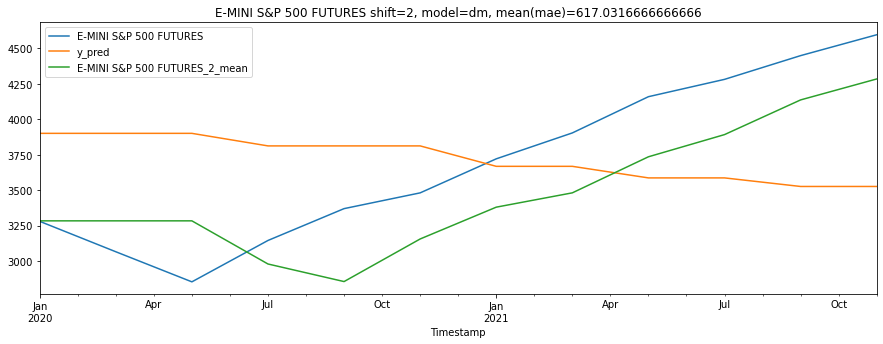

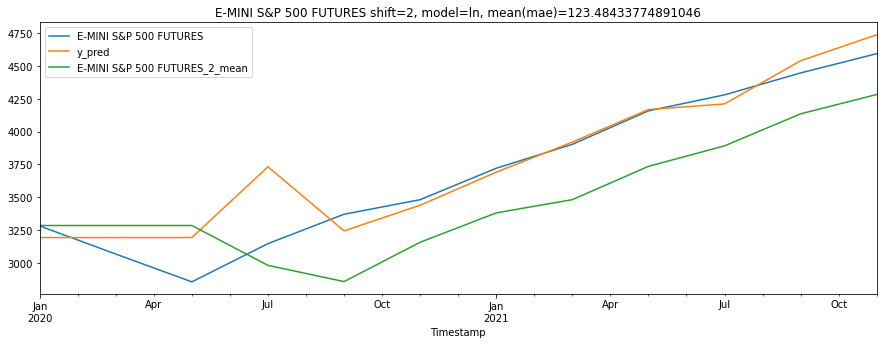

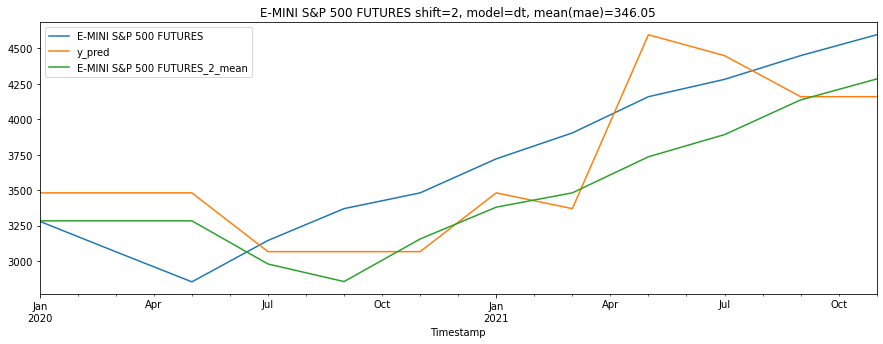

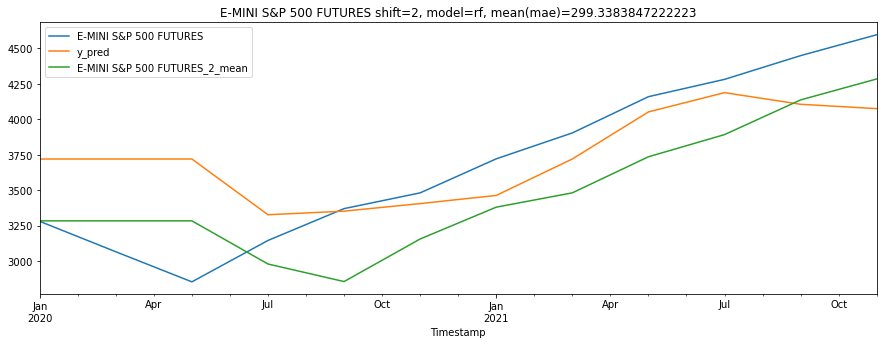

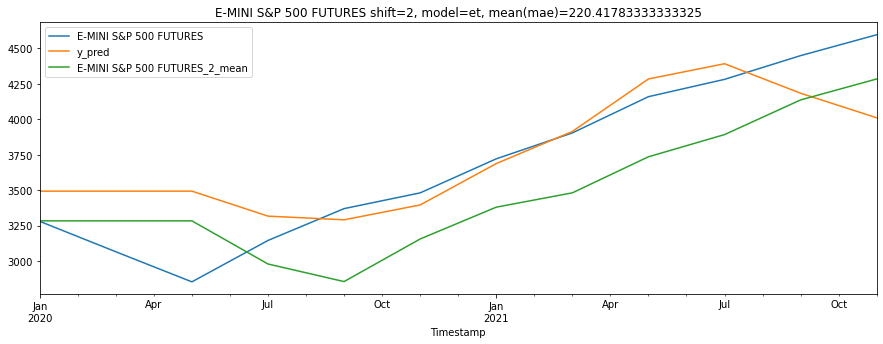

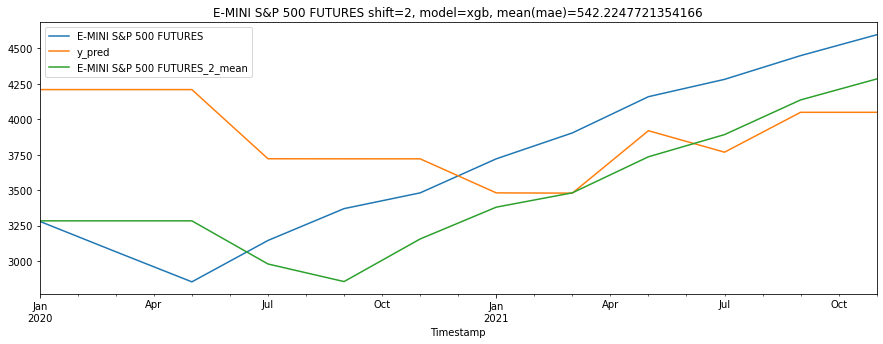

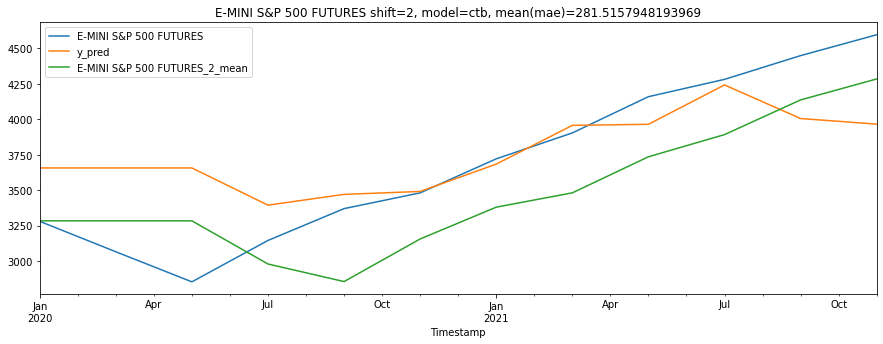

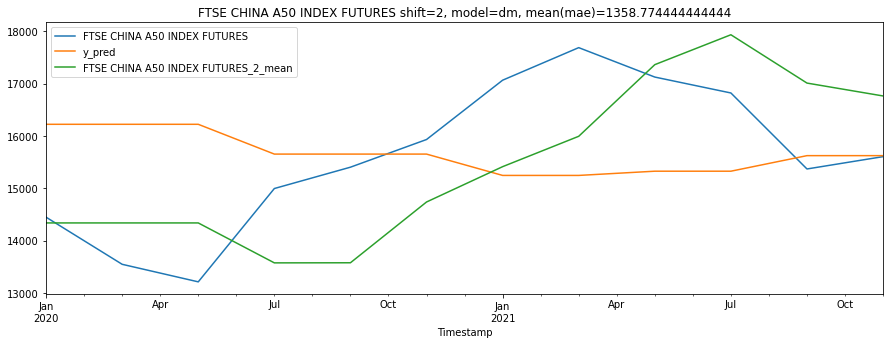

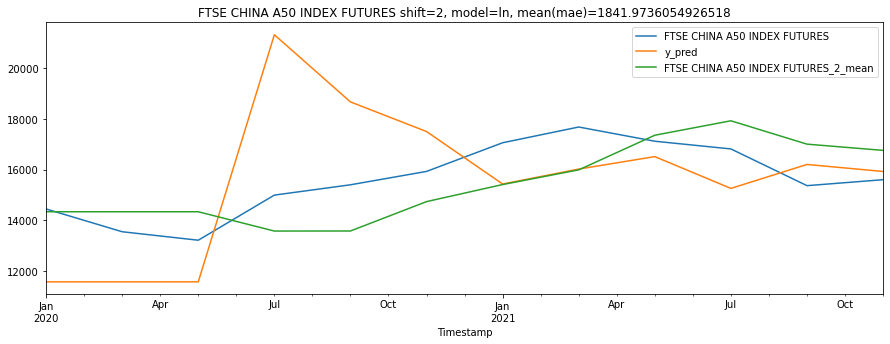

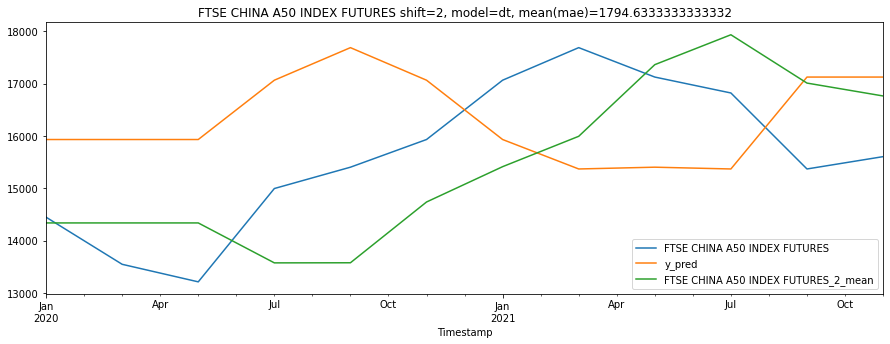

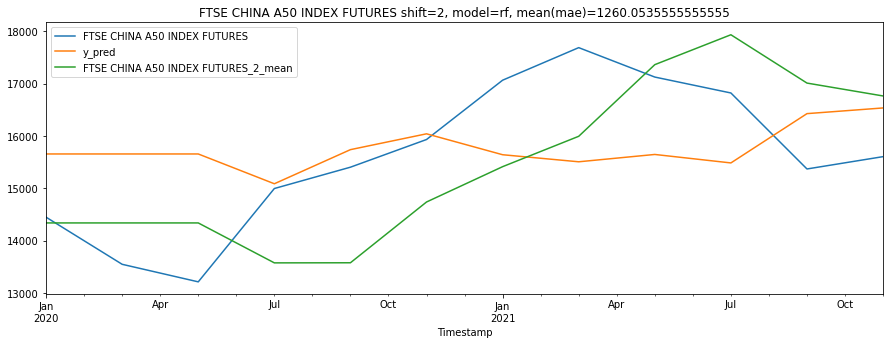

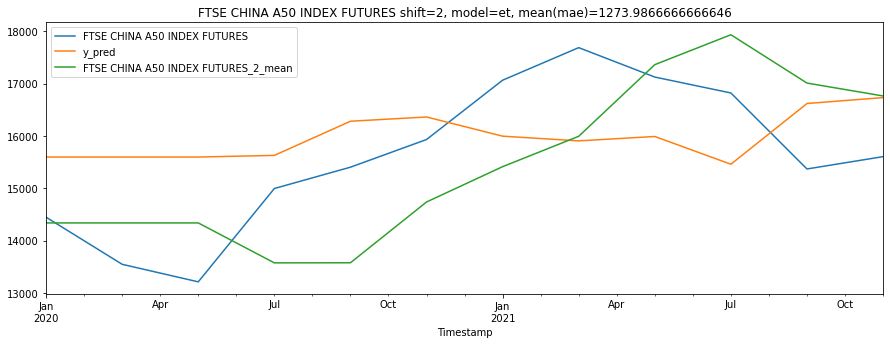

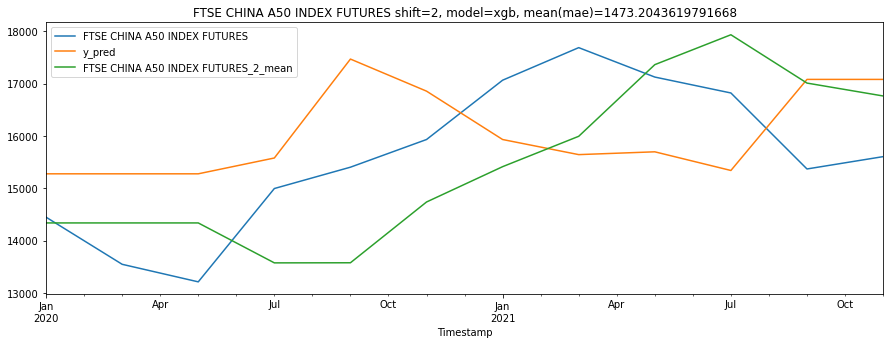

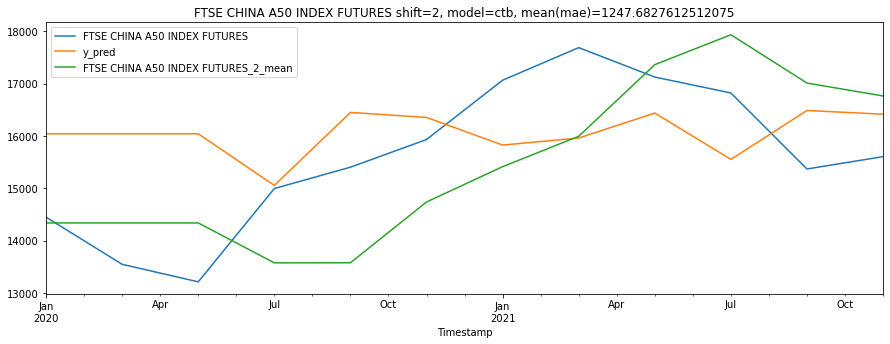

In [37]:
shift=2
for label in data.columns:
    feats = [x for x in data_agg2.columns if "_{}_".format(shift) in x]
    X = data_agg2[feats].values
    y = data_agg2[label].values

    ln_pipe = Pipeline([('scaler', StandardScaler()), ('ln', LinearRegression())])
    models = [
        ("dm", DummyRegressor()),
        ("ln", ln_pipe),
        ("dt", DecisionTreeRegressor(max_depth=10, random_state=0)),
        ("rf", RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("et", ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("xgb", xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0)),
        ("ctb", ctb.CatBoostRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0, verbose=0)),
    ]

    print(label)
    for model_name, model in models:
        scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
        data_agg2["y_pred"] = cross_val_predict(model, X, y, cv=5)
        
        roll_feat_mean = "{}_{}_{}".format(label, shift, "mean")
        data_agg2[[ label, "y_pred", roll_feat_mean]].plot(title="{} shift={}, model={}, mean(mae)={}".format(label, shift, model_name, np.mean(scores) * -1), figsize=(15, 5))
        print(model_name, np.mean(scores), np.std(scores))

#### Вывод: Из указанных выше числовых значений, а также на основе приведенного графика можно предположить, что наиболее привлекательной моделью является "ExtraTreesRegressor".¶

In [38]:
model = ExtraTreesRegressor()
model.fit(X, y)
eli5.show_weights(model, feature_names=feats)

In [39]:
def plot_importances(label, model, shift=2):
    feats = [x for x in data_agg2.columns if "_{}_".format(shift) in x]
    X = data_agg2[feats].values
    y = data_agg2[label].values

    
    model.fit(X, y)
    return eli5.show_weights(model, feature_names=feats)

In [40]:
plot_importances('10 YEAR TREASURY NOTE FUTURES', model=ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0), shift=2)

In [41]:
plot_importances('E-MINI S&P 500 FUTURES', model=ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0), shift=2)

In [42]:
plot_importances('FTSE CHINA A50 INDEX FUTURES', model=ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0), shift=2)

#### Вывод: Прогноз данных на 2 месяца показал, что данный прогноз цены фьючерсов 10 YEAR TREASURY NOTE FUTURES складывается на основе влияния цены на фьючерсы E-MINI S&P 500 FUTURES, а также на основе собственных исторических данных. При этом прогноз не учитывает влияние цены на фьючерсы FTSE CHINA A50 INDEX FUTURES. Возможно это объясняется тем фактом, что в течении анализируемого период уровень корреляции между указанными показателями был незначителен, а за 2-е полугодие он был практически равен нулю. При этом прогноз цены на фьючерсы E-MINI S&P 500 FUTURES в заданном промежутке времени учитывает в большей степени данные FTSE CHINA A50 INDEX FUTURES, что также объясняется исторической корреляцией между показателями. Однако следует учитывать, что во втором полугодие 2021 года данный показатель значительно снизился, что может отразиться на корректности данного вида прогноза. В свою очередь прогноз FTSE CHINA A50 INDEX FUTURES в значительной степени ориентируется на собственные исторические показатели и на данные цен на фьючерсы 10 YEAR TREASURY NOTE FUTURES. Таким образом, прогноз на 2 месяца учитывает не только собственные исторические данные, но и учитывает влияние прочих финансовых инструментов, на основе прошлых корреляционных данных.

## Этап 14.3
Строим прогноз сдвига на 3 месяца.

In [43]:
data_re3 = data.resample("3m").agg(["mean", "max", "min", "median", "std"])

data_agg3 = pd.DataFrame()
for x in data.columns:
    data_agg3[x] = data_re3[x]["median"] #этатлон, это с чем мы сверяемся (какую проблемы хотим решить или что будем прогнозироватьь)
    
    
data_agg3.head()

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-04-30                        135.000                 2853.25   
2020-07-31                        139.000                 3104.75   
2020-10-31                        138.984                 3384.00   
2021-01-31                        137.281                 3686.75   

            FTSE CHINA A50 INDEX FUTURES  
Timestamp                                 
2020-01-31                       14447.5  
2020-04-30                       13305.0  
2020-07-31                       13845.0  
2020-10-31                       15520.0  
2021-01-31                       16832.0

In [44]:
data_re3

10 YEAR TREASURY NOTE FUTURES                                       \
                                    mean      max      min   median       std   
Timestamp                                                                       
2020-01-31                    129.931969  135.000  128.156  129.359  1.478438   
2020-04-30                    135.566458  140.703  130.234  135.000  3.041360   
2020-07-31                    138.037336  140.187  135.000  139.000  1.879018   
2020-10-31                    138.098809  140.390  135.000  138.984  1.952986   
2021-01-31                    136.926400  139.265  135.000  137.281  1.347533   
2021-04-30                    133.956090  137.296  130.796  135.000  1.946248   
2021-07-31                    133.518463  135.187  131.765  133.390  1.121380   
2021-10-31                    133.162293  135.421  129.968  133.750  1.685532   
2022-01-31                    131.114062  135.000  129.515  130.734  1.322690   

           E-MINI S&P 500 FUTURES                                        \
                             mean      max     min   median         std   
Timestamp                                                                 
2020-01-31            3284.202878  3688.00  3182.0  3280.75   57.160052   
2020-04-30            2914.381717  3688.00  2174.0  2853.25  360.743965   
2020-07-31            3084.051489  3688.00  2761.5  3104.75  151.536859   
2020-10-31            3393.536290  3688.00  3199.5  3384.00   83.824716   
2021-01-31            3672.144003  3861.25  3243.5  3686.75  116.162516   
2021-04-30            3966.856924  4210.50  3688.0  3928.00  125.569331   
2021-07-31            4242.215473  4422.25  3688.0  4231.00  107.319025   
2021-10-31            4443.187932  4615.00  3688.0  4447.75   91.808356   
2022-01-31            4659.959370  4739.50  3688.0  4674.25   81.742214   

           FTSE CHINA A50 INDEX FUTURES                             \
                                   mean      max      min   median   
Timestamp                                                            
2020-01-31                 14337.797760  15604.0  12687.5  14447.5   
2020-04-30                 13528.932339  15604.0  11502.5  13305.0   
2020-07-31                 14412.944154  16340.0  12747.5  13845.0   
2020-10-31                 15513.119982  16245.0  14927.5  15520.0   
2021-01-31                 17000.842441  19100.0  15604.0  16832.0   
2021-04-30                 17584.676853  20589.0  15604.0  17310.0   
2021-07-31                 16880.331185  18559.0  14556.0  17031.0   
2021-10-31                 15450.383928  16297.0  14487.0  15491.0   
2022-01-31                 15551.283186  15837.0  15107.0  15581.0   

                         
                    std  
Timestamp                
2020-01-31   856.891406  
2020-04-30  1058.948156  
2020-07-31  1048.018471  
2020-10-31   257.654355  
2021-01-31  1030.535647  
2021-04-30  1313.092058  
2021-07-31   893.659959  
2021-10-31   365.252530  
2022-01-31   111.521974

In [45]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            data_agg3["{}_{}_{}".format(x, shift, agg_func)] = data_re3[x][agg_func].shift(shift).fillna(method="bfill")
    
data_agg3

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-04-30                        135.000                 2853.25   
2020-07-31                        139.000                 3104.75   
2020-10-31                        138.984                 3384.00   
2021-01-31                        137.281                 3686.75   
2021-04-30                        135.000                 3928.00   
2021-07-31                        133.390                 4231.00   
2021-10-31                        133.750                 4447.75   
2022-01-31                        130.734                 4674.25   

            FTSE CHINA A50 INDEX FUTURES  \
Timestamp                                  
2020-01-31                       14447.5   
2020-04-30                       13305.0   
2020-07-31                       13845.0   
2020-10-31                       15520.0   
2021-01-31                       16832.0   
2021-04-30                       17310.0   
2021-07-31                       17031.0   
2021-10-31                       15491.0   
2022-01-31                       15581.0   

            10 YEAR TREASURY NOTE FUTURES_1_mean  \
Timestamp                                          
2020-01-31                            129.931969   
2020-04-30                            129.931969   
2020-07-31                            135.566458   
2020-10-31                            138.037336   
2021-01-31                            138.098809   
2021-04-30                            136.926400   
2021-07-31                            133.956090   
2021-10-31                            133.518463   
2022-01-31                            133.162293   

            10 YEAR TREASURY NOTE FUTURES_1_max  \
Timestamp                                         
2020-01-31                              135.000   
2020-04-30                              135.000   
2020-07-31                              140.703   
2020-10-31                              140.187   
2021-01-31                              140.390   
2021-04-30                              139.265   
2021-07-31                              137.296   
2021-10-31                              135.187   
2022-01-31                              135.421   

            10 YEAR TREASURY NOTE FUTURES_1_min  \
Timestamp                                         
2020-01-31                              128.156   
2020-04-30                              128.156   
2020-07-31                              130.234   
2020-10-31                              135.000   
2021-01-31                              135.000   
2021-04-30                              135.000   
2021-07-31                              130.796   
2021-10-31                              131.765   
2022-01-31                              129.968   

            10 YEAR TREASURY NOTE FUTURES_1_median  \
Timestamp                                            
2020-01-31                                 129.359   
2020-04-30                                 129.359   
2020-07-31                                 135.000   
2020-10-31                                 139.000   
2021-01-31                                 138.984   
2021-04-30                                 137.281   
2021-07-31                                 135.000   
2021-10-31                                 133.390   
2022-01-31                                 133.750   

            10 YEAR TREASURY NOTE FUTURES_1_std  \
Timestamp                                         
2020-01-31                             1.478438   
2020-04-30                             1.478438   
2020-07-31                             3.041360   
2020-10-31                             1.879018   
2021-01-31                             1.952986   
2021-04-30                             1.347533   
2021-07-31                             1.946248   
2021-10-31      

In [46]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            score = mean_absolute_error(data_agg3[x], data_agg3["{}_{}_{}".format(x, shift, agg_func)])
            print(x, shift, agg_func, score)

10 YEAR TREASURY NOTE FUTURES 1 mean 1.7768150222689612
10 YEAR TREASURY NOTE FUTURES 1 max 2.8834444444444407
10 YEAR TREASURY NOTE FUTURES 1 min 3.1581111111111144
10 YEAR TREASURY NOTE FUTURES 1 median 2.069666666666668
10 YEAR TREASURY NOTE FUTURES 1 std 132.9518964167264
10 YEAR TREASURY NOTE FUTURES 2 mean 3.1676301523916695
10 YEAR TREASURY NOTE FUTURES 2 max 3.7255555555555526
10 YEAR TREASURY NOTE FUTURES 2 min 3.946333333333333
10 YEAR TREASURY NOTE FUTURES 2 median 3.640666666666666
10 YEAR TREASURY NOTE FUTURES 2 std 132.9749069125876
10 YEAR TREASURY NOTE FUTURES 3 mean 4.402248770642596
10 YEAR TREASURY NOTE FUTURES 3 max 4.590111111111109
10 YEAR TREASURY NOTE FUTURES 3 min 4.4097777777777765
10 YEAR TREASURY NOTE FUTURES 3 median 4.953222222222223
10 YEAR TREASURY NOTE FUTURES 3 std 132.93523379435123
10 YEAR TREASURY NOTE FUTURES 4 mean 5.207232871714044
10 YEAR TREASURY NOTE FUTURES 4 max 4.841888888888889
10 YEAR TREASURY NOTE FUTURES 4 min 5.637333333333332
10 YEAR 

10 YEAR TREASURY NOTE FUTURES
dm -3.310071428571433 1.529169084096031
ln -4.212141486096664 2.3159108344123145
dt -3.8423000000000003 2.507822254467009
rf -3.7145903166666585 2.3658015478542387
et -3.9051184999999835 2.4629220815758806
xgb -4.4218104980468755 1.9814737116979926
ctb -4.095603544326337 2.3945554080014704
E-MINI S&P 500 FUTURES
dm -688.7116071428571 316.33694728682894
ln -189.9338676461432 25.431156046000616
dt -336.1375 177.4469480577223
rf -323.78972083333315 189.05785143279482
et -261.6796874999999 147.37187670328026
xgb -356.0249267578125 191.7348119577697
ctb -285.83890369212065 158.85915837745463
FTSE CHINA A50 INDEX FUTURES
dm -1249.0696428571428 735.8233720358328
ln -1135.1272059901764 684.7953663204634
dt -1331.075 772.1673620401215
rf -1005.3002916666665 422.6566179242928
et -812.083875 486.13493873653545
xgb -712.88515625 318.5618102939647


/opt/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


ctb -977.6455950801462 380.4971503395884


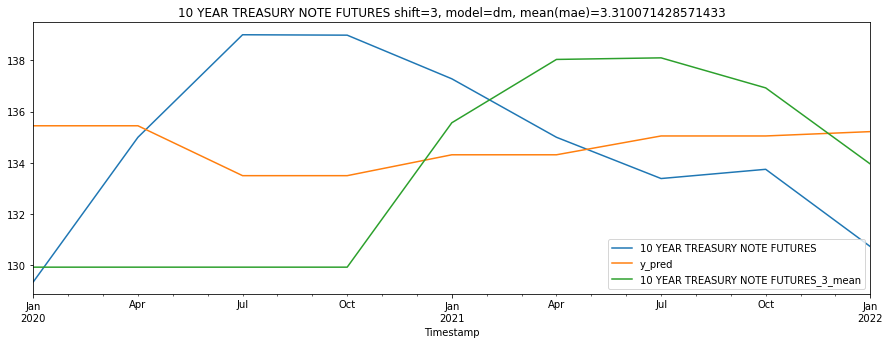

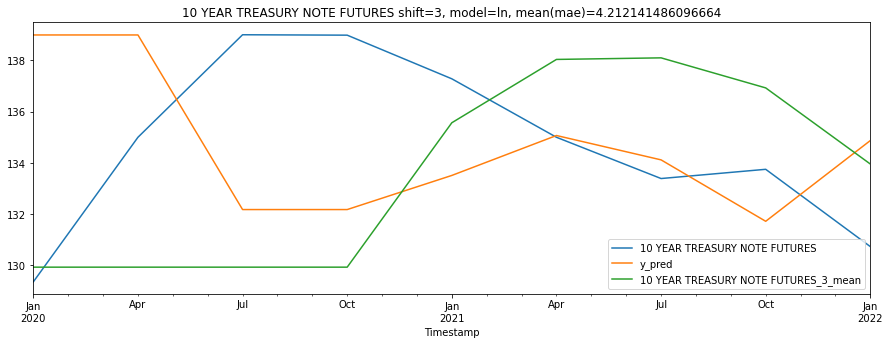

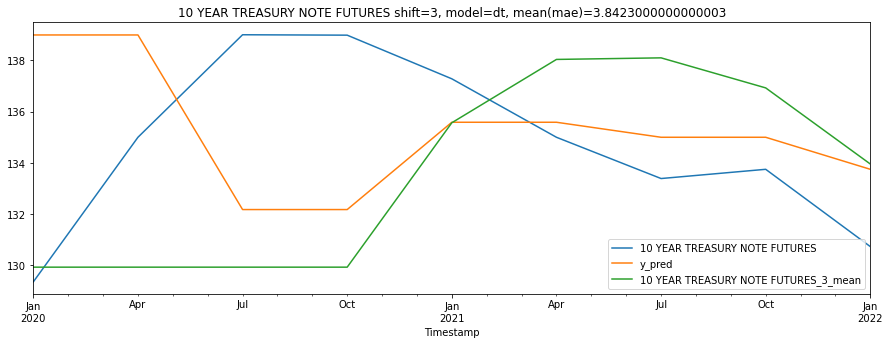

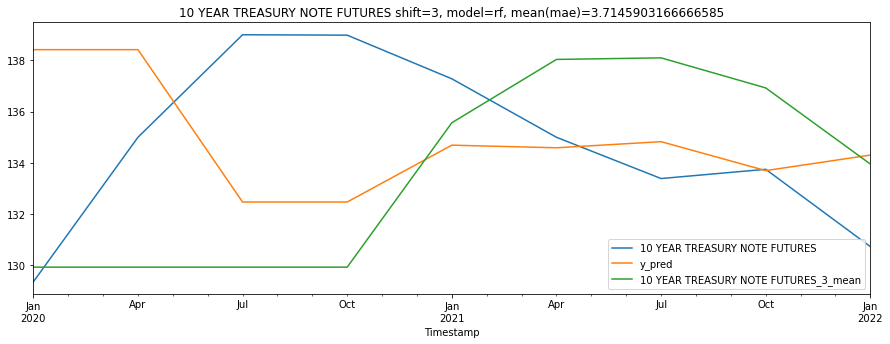

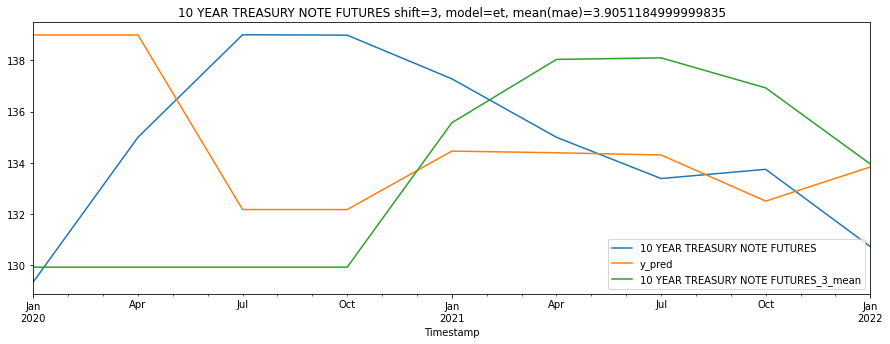

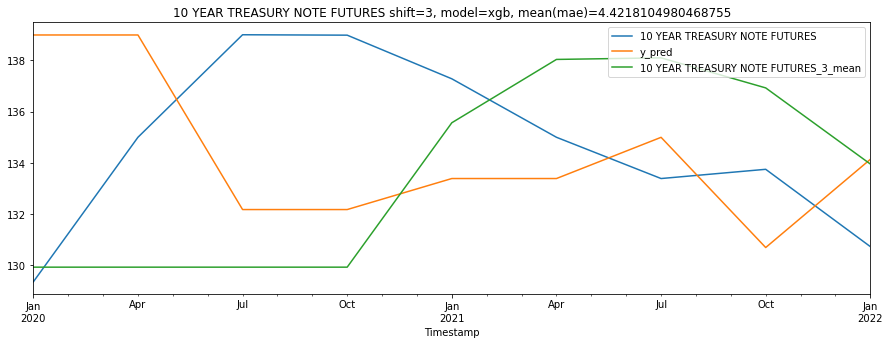

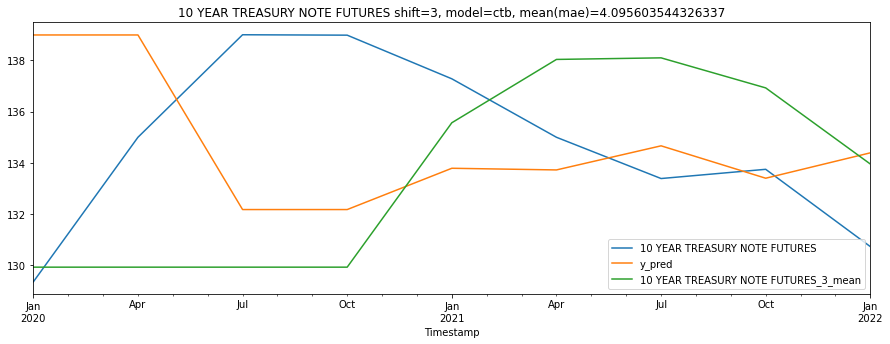

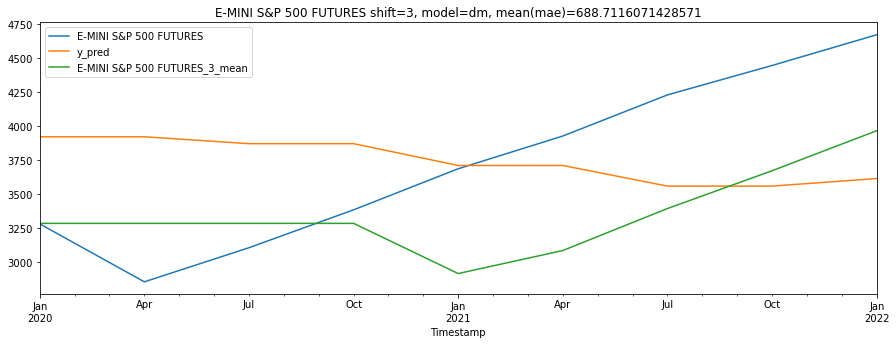

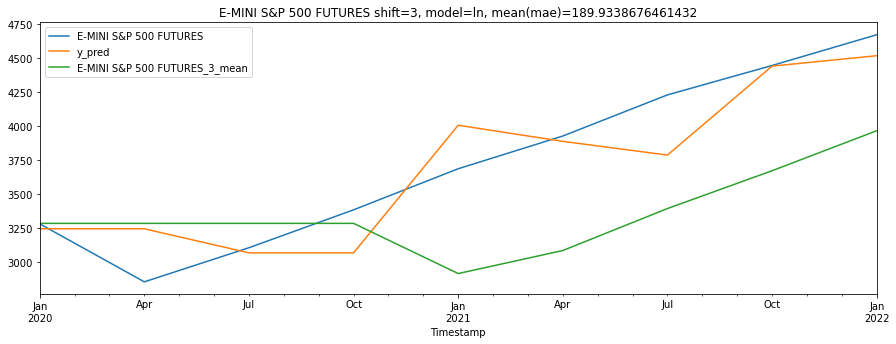

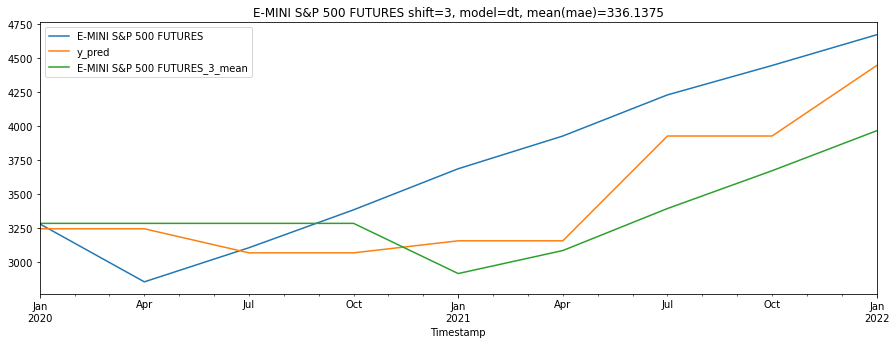

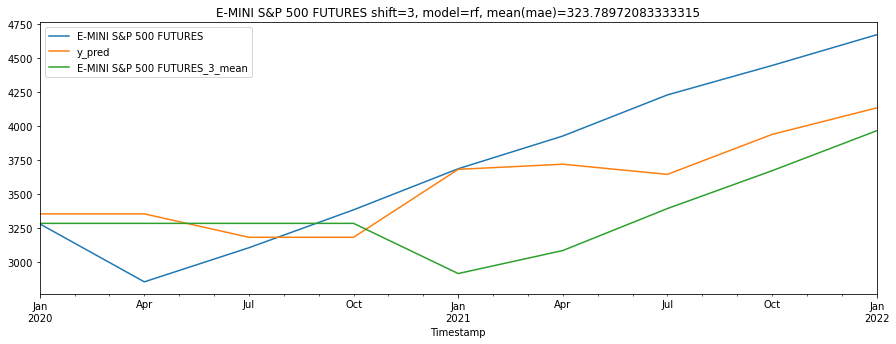

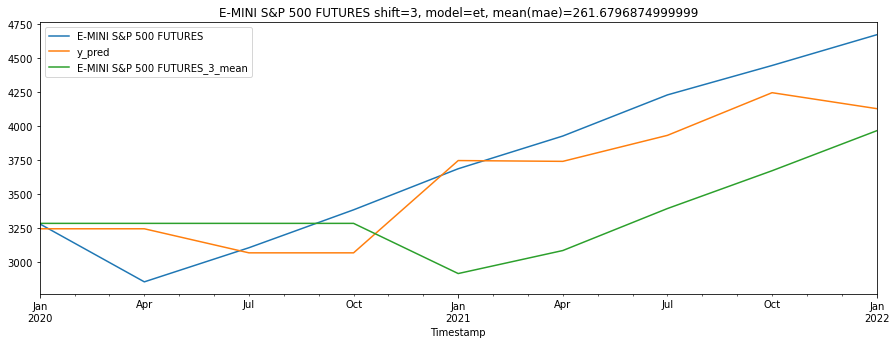

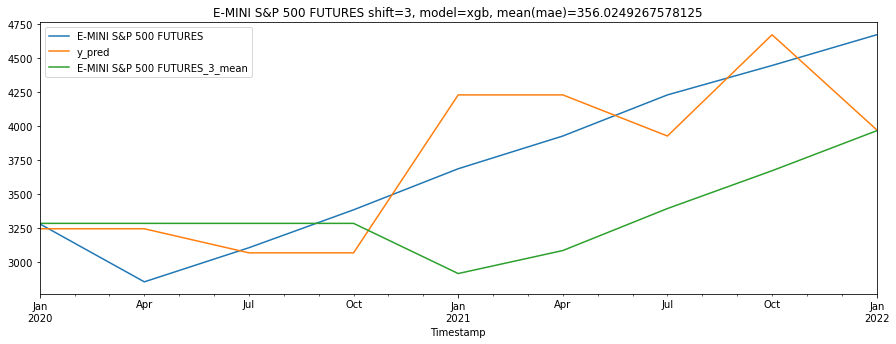

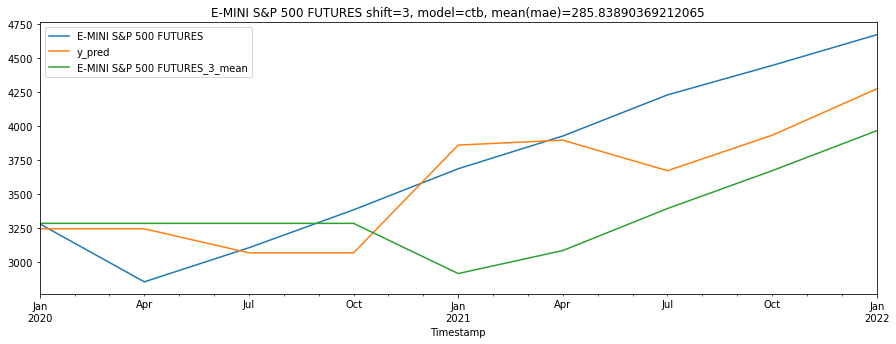

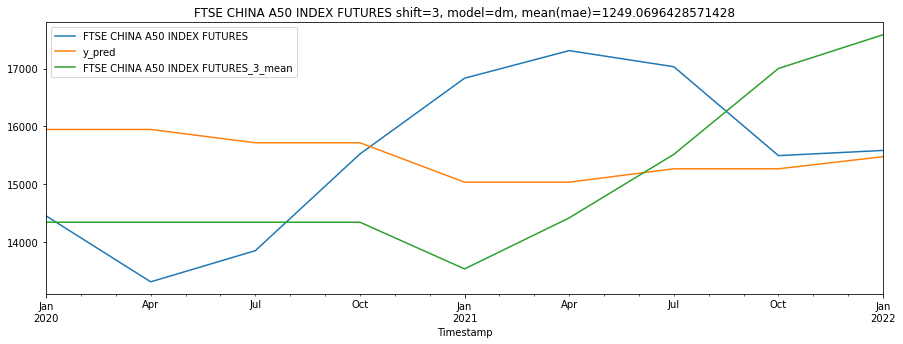

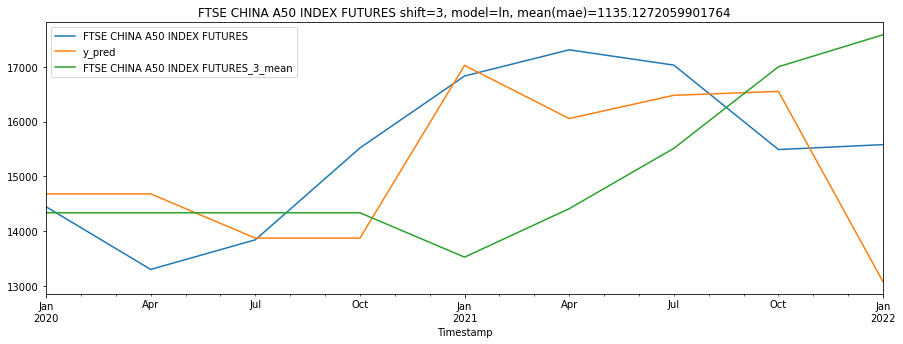

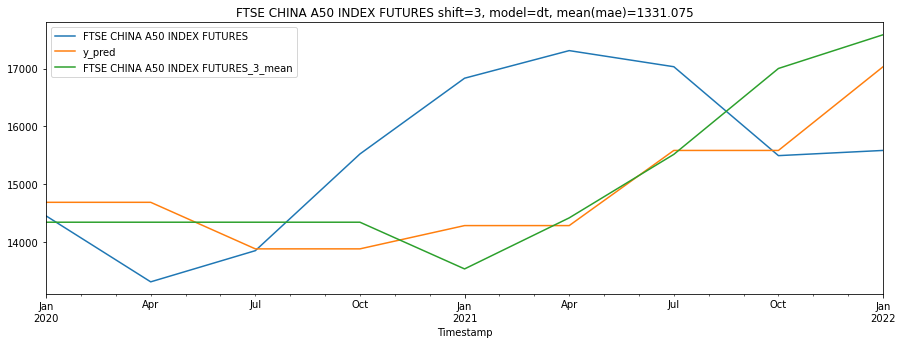

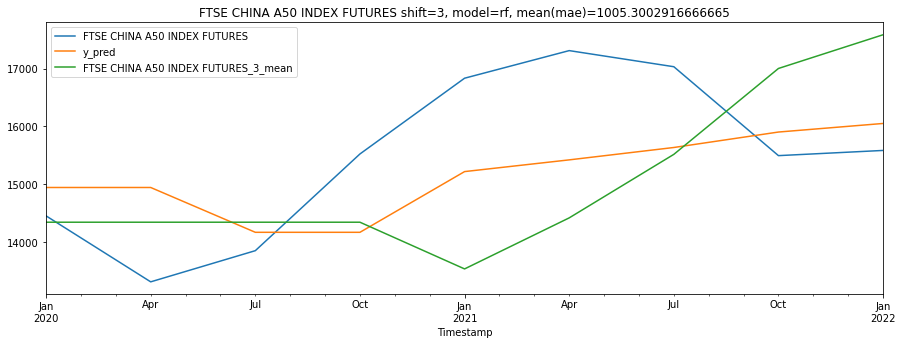

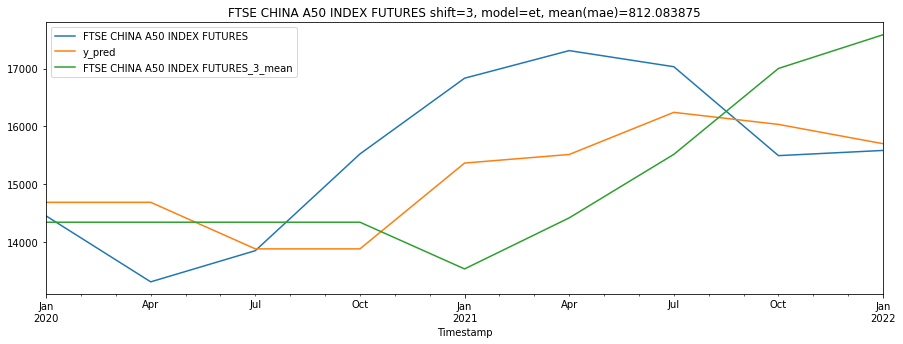

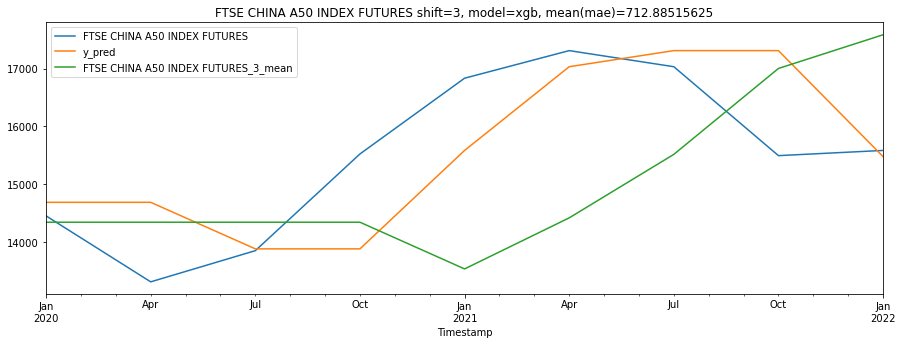

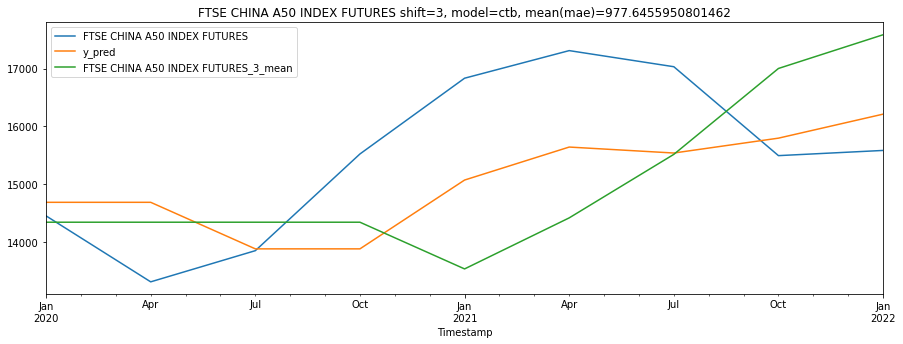

In [47]:
shift=3
for label in data.columns:
    feats = [x for x in data_agg3.columns if "_{}_".format(shift) in x]
    X = data_agg3[feats].values
    y = data_agg3[label].values

    ln_pipe = Pipeline([('scaler', StandardScaler()), ('ln', LinearRegression())])
    models = [
        ("dm", DummyRegressor()),
        ("ln", ln_pipe),
        ("dt", DecisionTreeRegressor(max_depth=10, random_state=0)),
        ("rf", RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("et", ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("xgb", xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0)),
        ("ctb", ctb.CatBoostRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0, verbose=0)),
    ]

    print(label)
    for model_name, model in models:
        scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
        data_agg3["y_pred"] = cross_val_predict(model, X, y, cv=5)
        
        roll_feat_mean = "{}_{}_{}".format(label, shift, "mean")
        data_agg3[[ label, "y_pred", roll_feat_mean]].plot(title="{} shift={}, model={}, mean(mae)={}".format(label, shift, model_name, np.mean(scores) * -1), figsize=(15, 5))
        print(model_name, np.mean(scores), np.std(scores))

#### Вывод: Из указанных выше числовых значений, а также на основе приведенного графика можно предположить, что наиболее привлекательной моделью является "Случайный лес".

In [48]:
model = RandomForestRegressor()
model.fit(X, y)
eli5.show_weights(model, feature_names=feats)

In [49]:
def plot_importances(label, model, shift=3):
    feats = [x for x in data_agg.columns if "_{}_".format(shift) in x]
    X = data_agg3[feats].values
    y = data_agg3[label].values

    
    model.fit(X, y)
    return eli5.show_weights(model, feature_names=feats)

In [50]:
plot_importances('10 YEAR TREASURY NOTE FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=3)

In [51]:
plot_importances('E-MINI S&P 500 FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=3)

In [52]:
plot_importances('FTSE CHINA A50 INDEX FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=3)

#### Вывод: Прогноз данных на 3 месяца показал, что в более долгосрочной перспективе, на прогнозное значение цены на фьючерсы 10 YEAR TREASURY NOTE FUTURES все таки влияет цена на фьючерсы FTSE CHINA A50 INDEX FUTURES, с которыми имеется исторически сложенный низкий уровень корреляции, и которые  не учитывались в прогнозе на 2 месяца.  Таким образом прогнозная цена на фьючерсы 10 YEAR TREASURY NOTE FUTURES складывается на основе влияния всех анализируемых финансовых инструментов, а также учитывают в том числе и собственные исторические данные. Тот факт, что при прогнозе на 3 месяца учитываются не только собственные значения, но и берутся в расчет влияние прочих инструментов, улучшает точность данного прогноза и делает его наиболее предпочтительным, в сравнении с вышеприведенным прогнозом на 1 месяц. Стоит отметить, что прогнозы цен на фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES не учитывают собственные исторические данные, и ориентируется в большей степени на данные двух других анализируемых инструментов.

## Этап 14.4
Строим прогноз сдвига на 4 месяца.

In [53]:
data_re4 = data.resample("4m").agg(["mean", "max", "min", "median", "std"])

data_agg4 = pd.DataFrame()
for x in data.columns:
    data_agg4[x] = data_re4[x]["median"] #этатлон, это с чем мы сверяемся (какую проблемы хотим решить или что будем прогнозироватьь)
    
    
data_agg4.head()

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-05-31                        137.734                 2880.25   
2020-09-30                        139.140                 3256.75   
2021-01-31                        137.843                 3647.00   
2021-05-31                        132.687                 3971.25   

            FTSE CHINA A50 INDEX FUTURES  
Timestamp                                 
2020-01-31                       14447.5  
2020-05-31                       13325.0  
2020-09-30                       15330.0  
2021-01-31                       16489.0  
2021-05-31                       17284.0

In [54]:
data_re4

10 YEAR TREASURY NOTE FUTURES                                       \
                                    mean      max      min   median       std   
Timestamp                                                                       
2020-01-31                    129.931969  135.000  128.156  129.359  1.478438   
2020-05-31                    136.296594  140.703  130.234  137.734  3.006600   
2020-09-30                    137.838513  140.390  135.000  139.140  2.132458   
2021-01-31                    137.347413  139.765  135.000  137.843  1.476531   
2021-05-31                    133.667375  137.296  130.796  132.687  1.813793   
2021-09-30                    133.980681  135.421  131.250  134.203  1.047153   
2022-01-31                    131.164934  135.000  129.515  130.843  1.179195   

           E-MINI S&P 500 FUTURES                                        \
                             mean      max     min   median         std   
Timestamp                                                                 
2020-01-31            3284.202878  3688.00  3182.0  3280.75   57.160052   
2020-05-31            2918.039324  3688.00  2174.0  2880.25  318.850086   
2020-09-30            3266.539206  3688.00  2938.0  3256.75  145.862791   
2021-01-31            3607.041560  3861.25  3226.5  3647.00  154.071562   
2021-05-31            4014.015768  4237.75  3688.0  3971.25  141.521693   
2021-09-30            4364.105790  4548.00  3688.0  4379.75  119.799730   
2022-01-31            4552.902771  4739.50  3688.0  4595.00  145.006875   

           FTSE CHINA A50 INDEX FUTURES                             \
                                   mean      max      min   median   
Timestamp                                                            
2020-01-31                 14337.797760  15604.0  12687.5  14447.5   
2020-05-31                 13575.914135  15604.0  11502.5  13325.0   
2020-09-30                 15069.045317  16340.0  13300.0  15330.0   
2021-01-31                 16669.220584  19100.0  14992.5  16489.0   
2021-05-31                 17469.943242  20589.0  15604.0  17284.0   
2021-09-30                 16037.899119  18306.0  14487.0  15604.0   
2022-01-31                 15634.734405  16297.0  14827.0  15604.0   

                         
                    std  
Timestamp                
2020-01-31   856.891406  
2020-05-31  1037.883291  
2020-09-30   752.359312  
2021-01-31  1059.542986  
2021-05-31  1229.097698  
2021-09-30   981.887729  
2022-01-31   265.180480

In [55]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            data_agg4["{}_{}_{}".format(x, shift, agg_func)] = data_re4[x][agg_func].shift(shift).fillna(method="bfill")
    
data_agg4

10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
Timestamp                                                           
2020-01-31                        129.359                 3280.75   
2020-05-31                        137.734                 2880.25   
2020-09-30                        139.140                 3256.75   
2021-01-31                        137.843                 3647.00   
2021-05-31                        132.687                 3971.25   
2021-09-30                        134.203                 4379.75   
2022-01-31                        130.843                 4595.00   

            FTSE CHINA A50 INDEX FUTURES  \
Timestamp                                  
2020-01-31                       14447.5   
2020-05-31                       13325.0   
2020-09-30                       15330.0   
2021-01-31                       16489.0   
2021-05-31                       17284.0   
2021-09-30                       15604.0   
2022-01-31                       15604.0   

            10 YEAR TREASURY NOTE FUTURES_1_mean  \
Timestamp                                          
2020-01-31                            129.931969   
2020-05-31                            129.931969   
2020-09-30                            136.296594   
2021-01-31                            137.838513   
2021-05-31                            137.347413   
2021-09-30                            133.667375   
2022-01-31                            133.980681   

            10 YEAR TREASURY NOTE FUTURES_1_max  \
Timestamp                                         
2020-01-31                              135.000   
2020-05-31                              135.000   
2020-09-30                              140.703   
2021-01-31                              140.390   
2021-05-31                              139.765   
2021-09-30                              137.296   
2022-01-31                              135.421   

            10 YEAR TREASURY NOTE FUTURES_1_min  \
Timestamp                                         
2020-01-31                              128.156   
2020-05-31                              128.156   
2020-09-30                              130.234   
2021-01-31                              135.000   
2021-05-31                              135.000   
2021-09-30                              130.796   
2022-01-31                              131.250   

            10 YEAR TREASURY NOTE FUTURES_1_median  \
Timestamp                                            
2020-01-31                                 129.359   
2020-05-31                                 129.359   
2020-09-30                                 137.734   
2021-01-31                                 139.140   
2021-05-31                                 137.843   
2021-09-30                                 132.687   
2022-01-31                                 134.203   

            10 YEAR TREASURY NOTE FUTURES_1_std  \
Timestamp                                         
2020-01-31                             1.478438   
2020-05-31                             1.478438   
2020-09-30                             3.006600   
2021-01-31                             2.132458   
2021-05-31                             1.476531   
2021-09-30                             1.813793   
2022-01-31                             1.047153   

            10 YEAR TREASURY NOTE FUTURES_2_mean  \
Timestamp                                          
2020-01-31                            129.931969   
2020-05-31                            129.931969   
2020-09-30                            129.931969   
2021-01-31                            136.296594   
2021-05-31                            137.838513   
2021-09-30                            137.347413   
2022-01-31                            133.667375   

            10 YEAR TREASURY NOTE FUTURES_2_max  ...  \
Timestamp                                        ...   
2020-01-31                              135.000  ...   
2020-05-31          

In [56]:
for x in data.columns:
    for shift in shifts:
        for agg_func in agg_funcs:
            score = mean_absolute_error(data_agg4[x], data_agg4["{}_{}_{}".format(x, shift, agg_func)])
            print(x, shift, agg_func, score)

10 YEAR TREASURY NOTE FUTURES 1 mean 2.7938018463942007
10 YEAR TREASURY NOTE FUTURES 1 max 3.890571428571426
10 YEAR TREASURY NOTE FUTURES 1 min 4.09385714285714
10 YEAR TREASURY NOTE FUTURES 1 median 3.0157142857142794
10 YEAR TREASURY NOTE FUTURES 1 std 132.7679412203063
10 YEAR TREASURY NOTE FUTURES 2 mean 4.321391133231474
10 YEAR TREASURY NOTE FUTURES 2 max 5.013285714285709
10 YEAR TREASURY NOTE FUTURES 2 min 4.647285714285707
10 YEAR TREASURY NOTE FUTURES 2 median 4.31457142857142
10 YEAR TREASURY NOTE FUTURES 2 std 132.70632910544424
10 YEAR TREASURY NOTE FUTURES 3 mean 5.606225855074415
10 YEAR TREASURY NOTE FUTURES 3 max 5.497571428571421
10 YEAR TREASURY NOTE FUTURES 3 min 5.5512857142857115
10 YEAR TREASURY NOTE FUTURES 3 median 6.231999999999991
10 YEAR TREASURY NOTE FUTURES 3 std 132.7542369552031
10 YEAR TREASURY NOTE FUTURES 4 mean 5.334028296799009
10 YEAR TREASURY NOTE FUTURES 4 max 4.816857142857137
10 YEAR TREASURY NOTE FUTURES 4 min 6.3012857142857115
10 YEAR TREA

10 YEAR TREASURY NOTE FUTURES
dm -3.3192933333333285 1.81574112807354
ln -5.96183769130509 3.5629919143845745
dt -4.124119999999996 0.719754928847302
rf -3.6083328666666348 1.6011803235044344
et -3.685179199999985 1.2238352832577453
xgb -3.8940968994140603 0.7432013012766099
ctb -3.5386821737990743 1.5431610291895432
E-MINI S&P 500 FUTURES
dm -671.4533333333334 287.8482444796216
ln -1002.8381398905883 898.6740521749766
dt -569.5475 365.22507396124934
rf -581.1035833333337 259.7147479525713
et -512.3380999999986 253.54482742197618
xgb -375.0373046875 210.26980271348168
ctb -579.1174275308107 253.67307192977606
FTSE CHINA A50 INDEX FUTURES
dm -1072.9600000000003 906.4395006838571
ln -1277.7774417223295 973.6102044845478
dt -1197.4216666666664 1051.4380886512845
rf -1167.7107333333333 1034.840121497297
et -1200.1684666666679 1046.2784663289426
xgb -1151.6443359375 1096.6201688611407


/opt/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


ctb -1213.9542283668402 1032.0140240104536


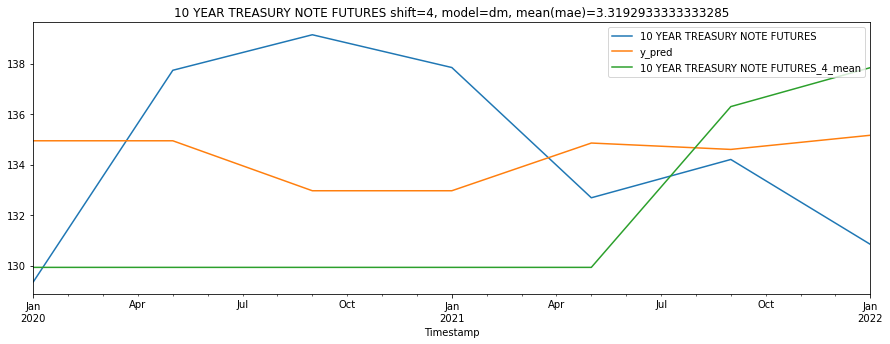

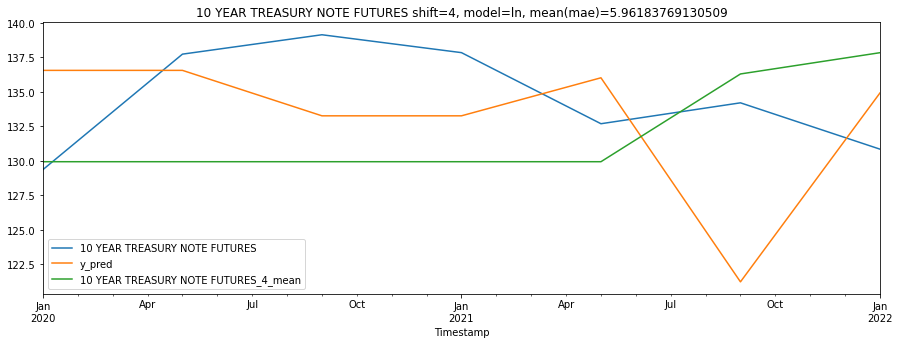

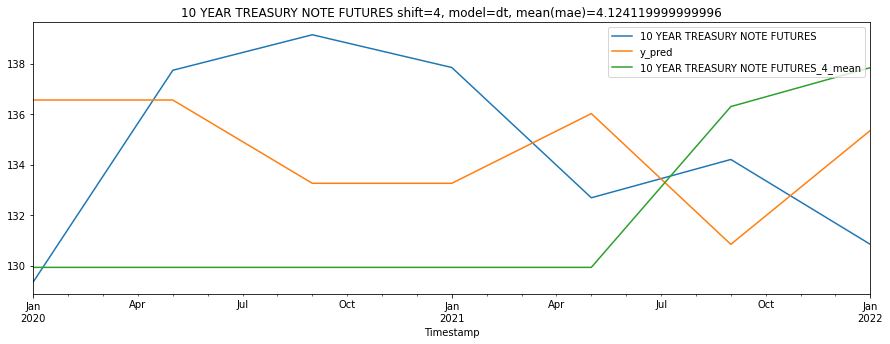

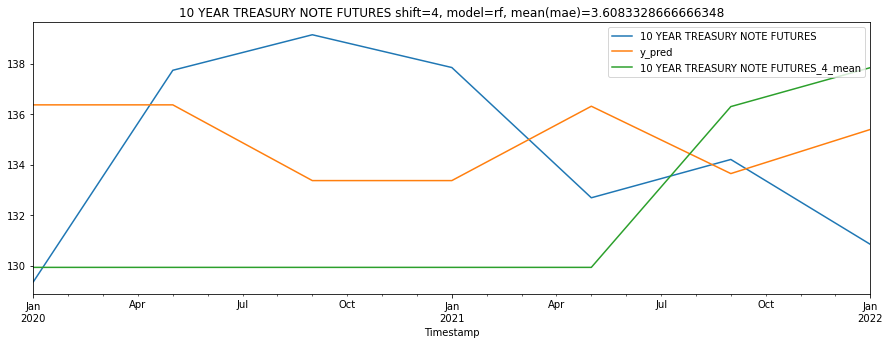

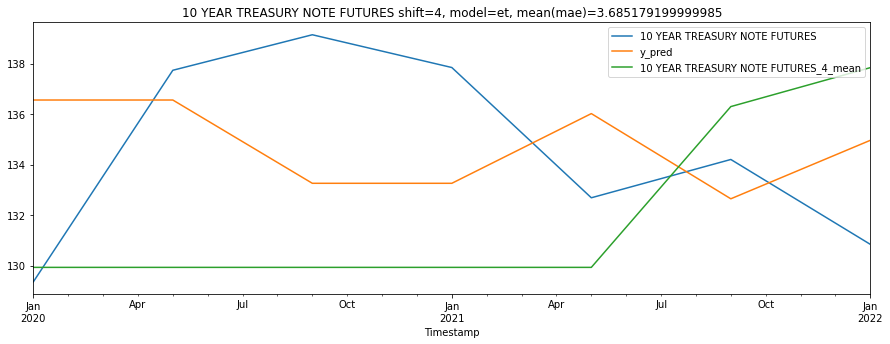

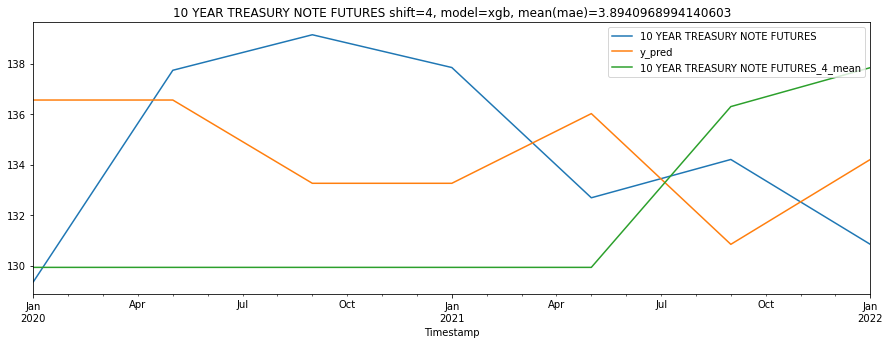

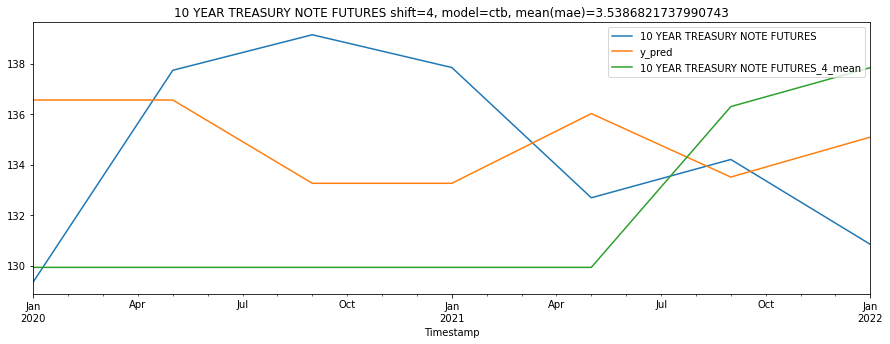

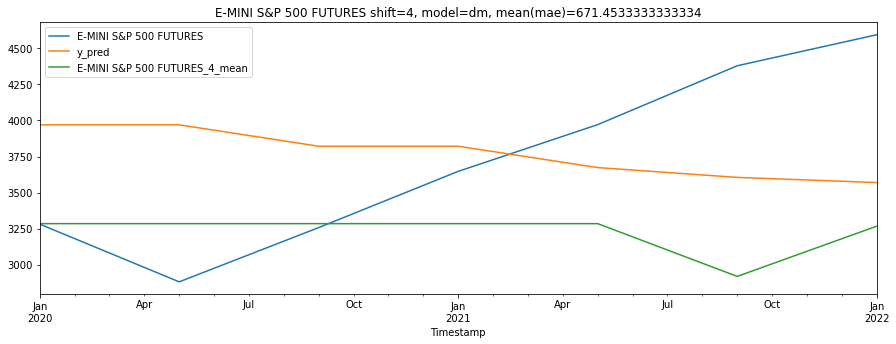

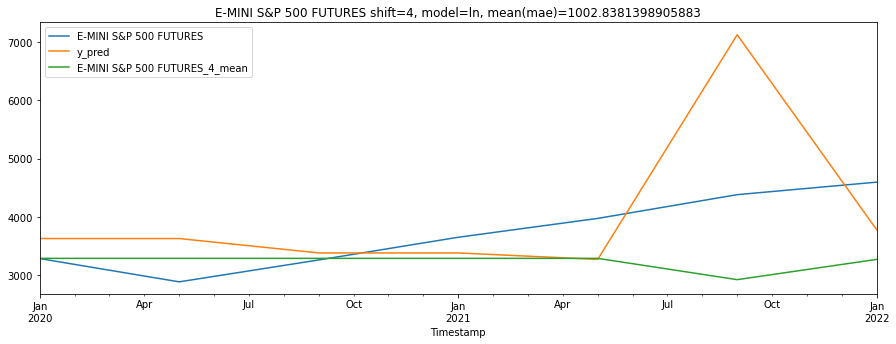

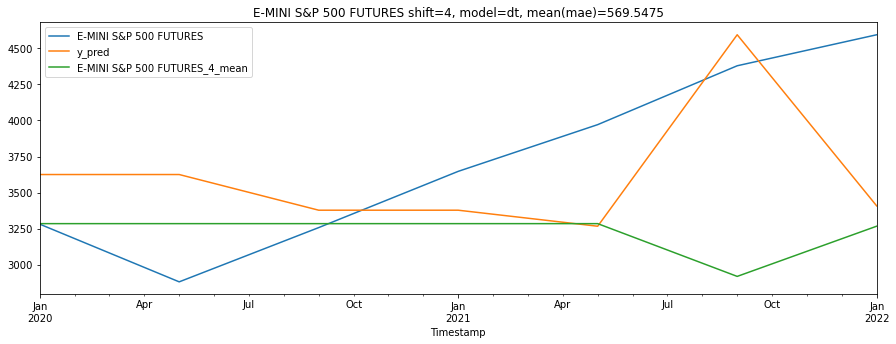

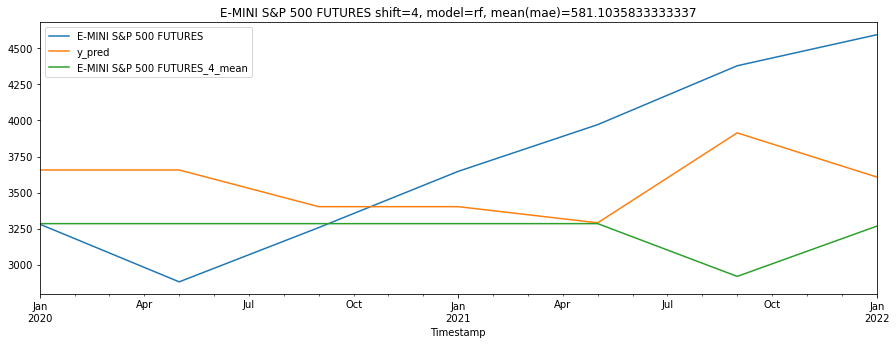

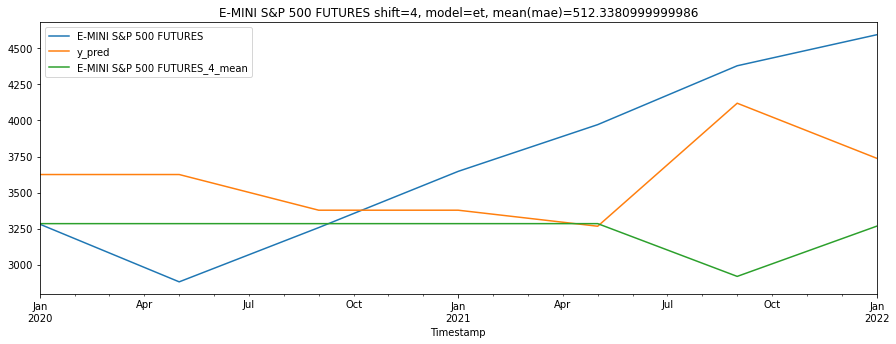

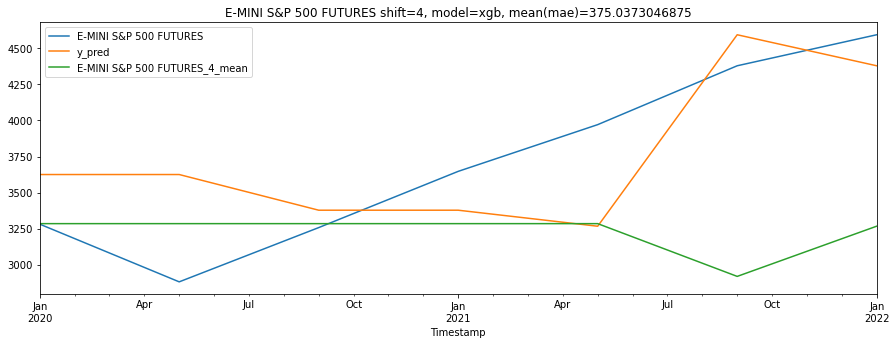

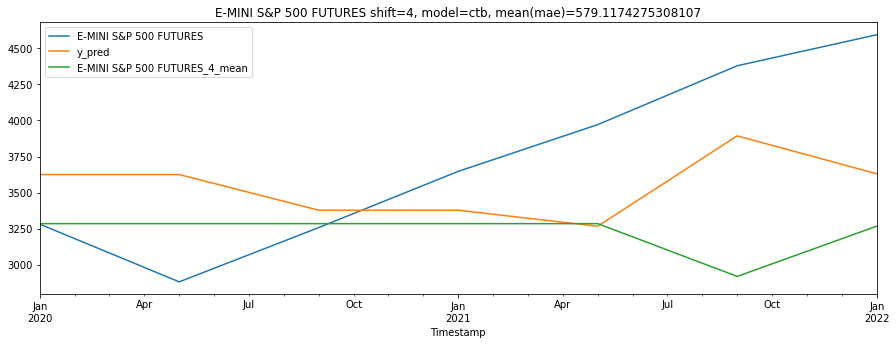

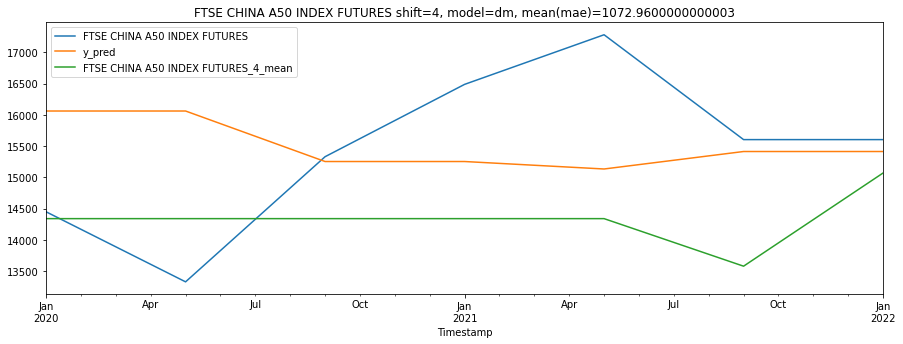

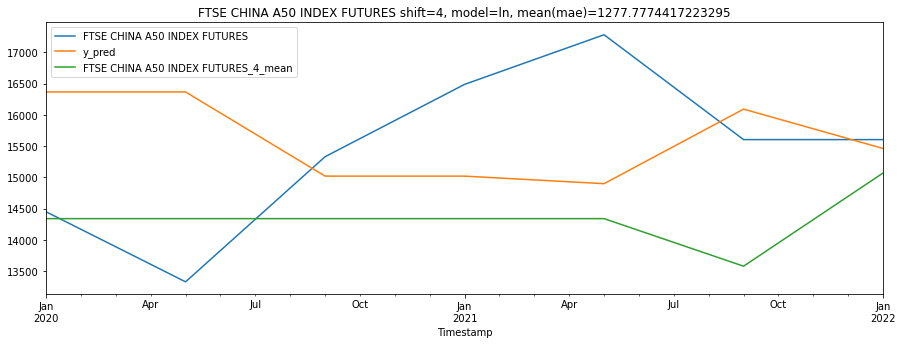

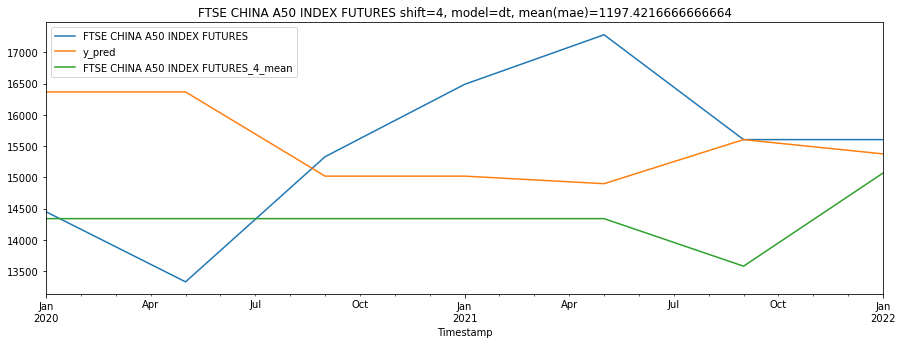

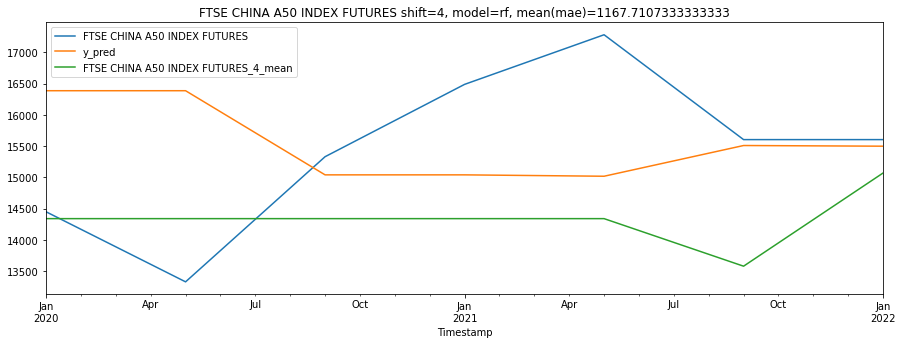

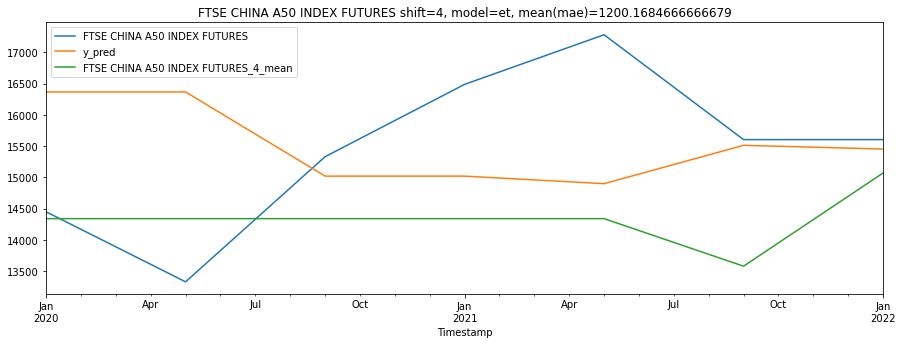

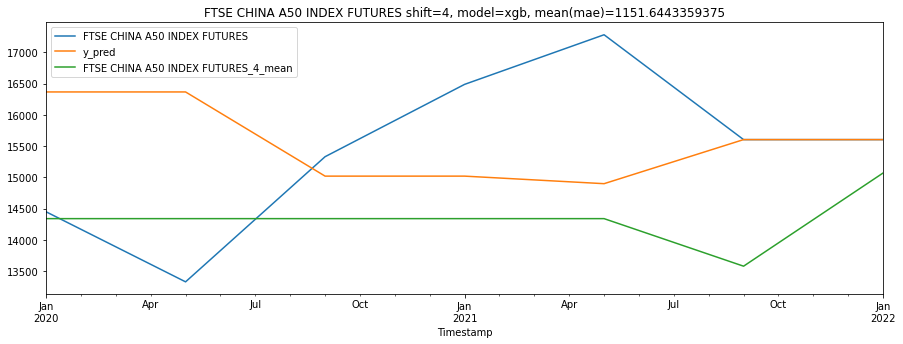

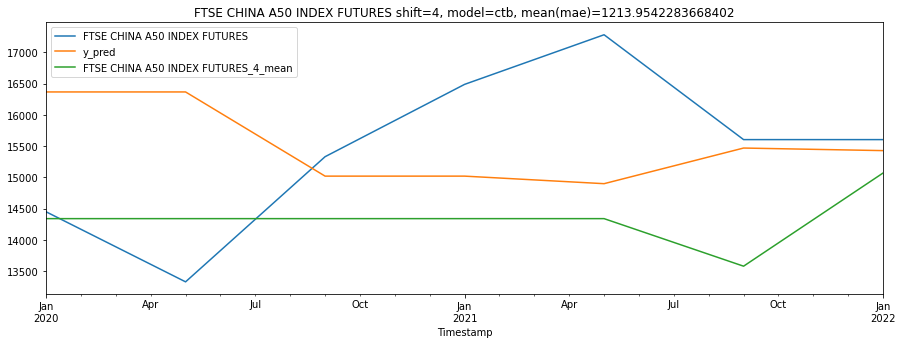

In [57]:
shift=4
for label in data.columns:
    feats = [x for x in data_agg4.columns if "_{}_".format(shift) in x]
    X = data_agg4[feats].values
    y = data_agg4[label].values

    ln_pipe = Pipeline([('scaler', StandardScaler()), ('ln', LinearRegression())])
    models = [
        ("dm", DummyRegressor()),
        ("ln", ln_pipe),
        ("dt", DecisionTreeRegressor(max_depth=10, random_state=0)),
        ("rf", RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("et", ExtraTreesRegressor(max_depth=10, n_estimators=100, random_state=0)),
        ("xgb", xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0)),
        ("ctb", ctb.CatBoostRegressor(max_depth=10, n_estimators=100, learning_rate=0.25, random_state=0, verbose=0)),
    ]

    print(label)
    for model_name, model in models:
        scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
        data_agg4["y_pred"] = cross_val_predict(model, X, y, cv=5)
        
        roll_feat_mean = "{}_{}_{}".format(label, shift, "mean")
        data_agg4[[ label, "y_pred", roll_feat_mean]].plot(title="{} shift={}, model={}, mean(mae)={}".format(label, shift, model_name, np.mean(scores) * -1), figsize=(15, 5))
        print(model_name, np.mean(scores), np.std(scores))

#### Вывод: Из указанных выше числовых значений, а также на основе приведенного графика можно предположить, что наиболее привлекательной моделью является "Случайный лес".

In [58]:
model = RandomForestRegressor()
model.fit(X, y)
eli5.show_weights(model, feature_names=feats)

In [59]:
def plot_importances(label, model, shift=4):
    feats = [x for x in data_agg.columns if "_{}_".format(shift) in x]
    X = data_agg4[feats].values
    y = data_agg4[label].values

    
    model.fit(X, y)
    return eli5.show_weights(model, feature_names=feats)

In [64]:
plot_importances('10 YEAR TREASURY NOTE FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=4)

In [65]:
plot_importances('E-MINI S&P 500 FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=4)

In [66]:
plot_importances('FTSE CHINA A50 INDEX FUTURES', model=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0), shift=4)

## Итоговые выводы:
### 1) Основываясь на вышеприведенных моделях прогноза показателя цена фьючерсов, можно определить, что при построении прогноза сроком более чем на 4 месяца возникает проблема отсутствия данных, так как для анализа были взяты данные менее чем за двухлетний период. Следовательно прогноз данных на период превышающем 4 месяца будет являться неэффективным. Кроме того, при построении прогноза менее чем на 1 месяц не учитываются внешние факторы. При таком прогнозе каждый показатель в значительной степени учитывает только свои исторические данные, не беря в расчет существующие зависимости с другими показателями. Следовательно для целей данного прогноза, с учетом вышеприведенной информации, на основе предоставленных данных можно использовать прогнозы на период 2-4 месяцев, рассчитанный методами RandomForestRegressor и ExtraTreesRegressor.
### 2) За весь анализируемый период установлено, что между показателями 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES присутствует наибольший уровень отрицательной корреляции на уровне -0,61. При этом фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES практически не коррелируют между собой. Между показателями E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES присутствует положительная корреляция на уровне 0,58.
### 3) Проведя анализ по полугодиям установлено, что корреляция между фьючерсами E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES увеличивалась в первые три полугодия анализируемого периода.
### 4) Наибольшее количество разрывов присутствует в данных 10 YEAR TREASURY NOTE FUTURES. При этом имеет место скачкообразный прирост по отсутствующим данным, что свидетельствует о том, что в определенные периоды имелись существенные пропуски данных. Более того, следует отметить наличие некой закономерности в указанных пропусках. Таким образом, в каждом из анализируемых годов данные отсутствовали в аналогичные периоды, а именно: с март-апрель, июнь-июль, сентябрь-октябрь и декабрь-январь. У двух других показателей, FTSE CHINA A50 INDEX FUTURES и E-MINI S&P 500 FUTURE, отсутствие данных возникает равномерно, в течение всего анализируемого периода. При этом на графике наглядно видно, что E-MINI S&P 500 FUTURE содержит наименьшее количество пропусков, указанная кривая практически не растет по истечению времени, на фоне существенного роста двух других показателей.
### 5) Можно предположить, что прогнозные модели с использованием деревьев (RandomForestRegressor, ExtraTreesRegressor) являются наиболее оптимальными при входных данных соответствующего DataFrame. Модели с применением бустинга не применимы так как зачастую модель переучивается, либо не хватает соответствующих данных как количественных, так и качественных.